In [1]:
from __future__ import print_function, division

import keras
import pandas as pd
from scipy.interpolate import interp1d




from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np


Using TensorFlow backend.
/home/chatbot/python/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chatbot/python/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chatbot/python/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chatbot/python/lib64/python3.6/site-packages/tenso

In [2]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

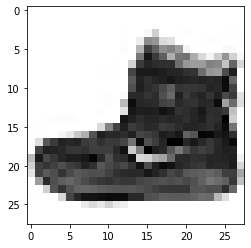

In [4]:
plt.imshow(x_train[0], cmap='Greys')

In [5]:
x_train = x_train/127.5-1

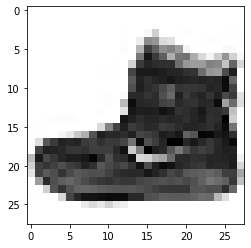

In [6]:
plt.imshow(x_train[0], cmap='Greys')

In [7]:
x_train = np.expand_dims(x_train, axis=3)

W1004 10:51:46.533183 140719177320256 deprecation_wrapper.py:119] From /home/chatbot/python/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1004 10:51:46.537235 140719177320256 deprecation_wrapper.py:119] From /home/chatbot/python/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 10:51:46.563215 140719177320256 deprecation_wrapper.py:119] From /home/chatbot/python/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1004 10:51:46.741836 140719177320256 deprecation_wrapper.py:119] From /home/chatbot/python/lib64/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1004 10

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              1607680   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)              

W1004 10:51:46.943961 140719177320256 deprecation_wrapper.py:119] From /home/chatbot/python/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_8 (Dense)              (None, 1024)             

/home/chatbot/python/lib64/python3.6/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.632519, acc.: 50.00%] [G loss: 0.305429]


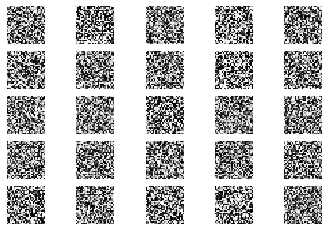

/home/chatbot/python/lib64/python3.6/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.667019, acc.: 50.00%] [G loss: 0.689952]
2 [D loss: 0.205392, acc.: 98.44%] [G loss: 1.561034]
3 [D loss: 0.094971, acc.: 100.00%] [G loss: 2.602530]
4 [D loss: 0.052526, acc.: 100.00%] [G loss: 3.304907]
5 [D loss: 0.022325, acc.: 100.00%] [G loss: 3.839556]
6 [D loss: 0.078612, acc.: 98.44%] [G loss: 3.624774]
7 [D loss: 0.031361, acc.: 100.00%] [G loss: 3.796942]
8 [D loss: 0.025301, acc.: 100.00%] [G loss: 4.465578]
9 [D loss: 0.016416, acc.: 100.00%] [G loss: 5.058372]
10 [D loss: 0.007041, acc.: 100.00%] [G loss: 5.440457]
11 [D loss: 0.009504, acc.: 100.00%] [G loss: 5.551137]
12 [D loss: 0.007622, acc.: 100.00%] [G loss: 5.707442]
13 [D loss: 0.011276, acc.: 100.00%] [G loss: 6.214853]
14 [D loss: 0.010109, acc.: 100.00%] [G loss: 6.426065]
15 [D loss: 0.005905, acc.: 100.00%] [G loss: 6.566864]
16 [D loss: 0.005879, acc.: 100.00%] [G loss: 6.584966]
17 [D loss: 0.009617, acc.: 100.00%] [G loss: 7.227036]
18 [D loss: 0.061094, acc.: 98.44%] [G loss: 7.637538]
19 [D

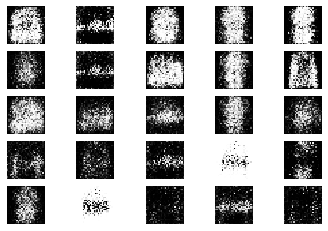

201 [D loss: 0.652568, acc.: 64.06%] [G loss: 4.227675]
202 [D loss: 0.340096, acc.: 89.06%] [G loss: 4.207157]
203 [D loss: 0.500635, acc.: 71.88%] [G loss: 4.531782]
204 [D loss: 0.336000, acc.: 82.81%] [G loss: 3.986688]
205 [D loss: 0.549006, acc.: 73.44%] [G loss: 5.148504]
206 [D loss: 0.647976, acc.: 70.31%] [G loss: 5.286489]
207 [D loss: 0.446883, acc.: 82.81%] [G loss: 5.226309]
208 [D loss: 0.292418, acc.: 84.38%] [G loss: 4.509360]
209 [D loss: 0.352373, acc.: 84.38%] [G loss: 5.284059]
210 [D loss: 0.305124, acc.: 93.75%] [G loss: 4.638494]
211 [D loss: 0.307995, acc.: 87.50%] [G loss: 4.638999]
212 [D loss: 0.248151, acc.: 92.19%] [G loss: 5.514511]
213 [D loss: 0.595464, acc.: 68.75%] [G loss: 4.824999]
214 [D loss: 0.275528, acc.: 84.38%] [G loss: 5.200906]
215 [D loss: 0.423425, acc.: 78.12%] [G loss: 4.101957]
216 [D loss: 0.453798, acc.: 75.00%] [G loss: 6.075863]
217 [D loss: 0.462270, acc.: 78.12%] [G loss: 5.355622]
218 [D loss: 0.413699, acc.: 84.38%] [G loss: 4.

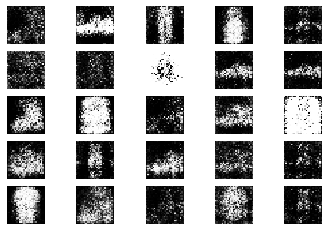

401 [D loss: 0.369369, acc.: 81.25%] [G loss: 4.469088]
402 [D loss: 0.401229, acc.: 75.00%] [G loss: 4.197617]
403 [D loss: 0.654478, acc.: 65.62%] [G loss: 3.837667]
404 [D loss: 0.392834, acc.: 82.81%] [G loss: 5.171765]
405 [D loss: 0.538208, acc.: 75.00%] [G loss: 3.251347]
406 [D loss: 0.284213, acc.: 89.06%] [G loss: 4.639822]
407 [D loss: 0.460515, acc.: 76.56%] [G loss: 3.313714]
408 [D loss: 0.412946, acc.: 79.69%] [G loss: 4.986780]
409 [D loss: 0.464639, acc.: 75.00%] [G loss: 4.973135]
410 [D loss: 0.408338, acc.: 79.69%] [G loss: 3.682363]
411 [D loss: 0.401671, acc.: 76.56%] [G loss: 4.659862]
412 [D loss: 0.275860, acc.: 90.62%] [G loss: 3.679843]
413 [D loss: 0.349980, acc.: 81.25%] [G loss: 4.579773]
414 [D loss: 0.502373, acc.: 71.88%] [G loss: 6.216137]
415 [D loss: 0.304169, acc.: 84.38%] [G loss: 4.305944]
416 [D loss: 0.832616, acc.: 53.12%] [G loss: 3.217567]
417 [D loss: 0.273710, acc.: 89.06%] [G loss: 4.865251]
418 [D loss: 0.843668, acc.: 57.81%] [G loss: 4.

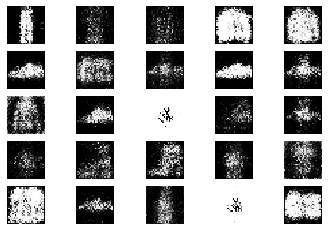

601 [D loss: 0.348977, acc.: 84.38%] [G loss: 2.729262]
602 [D loss: 0.375526, acc.: 81.25%] [G loss: 3.216652]
603 [D loss: 0.379634, acc.: 82.81%] [G loss: 3.319350]
604 [D loss: 0.485947, acc.: 71.88%] [G loss: 3.237117]
605 [D loss: 0.471582, acc.: 76.56%] [G loss: 2.321002]
606 [D loss: 0.408555, acc.: 76.56%] [G loss: 2.529418]
607 [D loss: 0.400760, acc.: 79.69%] [G loss: 3.733574]
608 [D loss: 0.415937, acc.: 79.69%] [G loss: 2.823628]
609 [D loss: 0.627401, acc.: 67.19%] [G loss: 2.587687]
610 [D loss: 0.462175, acc.: 78.12%] [G loss: 2.776402]
611 [D loss: 0.446186, acc.: 75.00%] [G loss: 2.387038]
612 [D loss: 0.464707, acc.: 75.00%] [G loss: 3.171187]
613 [D loss: 0.290386, acc.: 85.94%] [G loss: 2.655572]
614 [D loss: 0.416988, acc.: 85.94%] [G loss: 2.907676]
615 [D loss: 0.306720, acc.: 87.50%] [G loss: 3.513652]
616 [D loss: 0.502689, acc.: 73.44%] [G loss: 3.447801]
617 [D loss: 0.375843, acc.: 85.94%] [G loss: 4.317624]
618 [D loss: 0.352169, acc.: 84.38%] [G loss: 3.

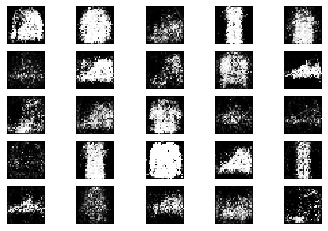

801 [D loss: 0.697107, acc.: 67.19%] [G loss: 3.260482]
802 [D loss: 0.362435, acc.: 81.25%] [G loss: 2.635733]
803 [D loss: 0.577720, acc.: 68.75%] [G loss: 2.130752]
804 [D loss: 0.391165, acc.: 89.06%] [G loss: 3.685822]
805 [D loss: 0.402576, acc.: 84.38%] [G loss: 2.057357]
806 [D loss: 0.353055, acc.: 82.81%] [G loss: 3.123250]
807 [D loss: 0.386354, acc.: 82.81%] [G loss: 2.377392]
808 [D loss: 0.298747, acc.: 89.06%] [G loss: 2.596876]
809 [D loss: 0.320144, acc.: 84.38%] [G loss: 2.576627]
810 [D loss: 0.403602, acc.: 84.38%] [G loss: 2.174479]
811 [D loss: 0.326306, acc.: 84.38%] [G loss: 3.048448]
812 [D loss: 0.445149, acc.: 78.12%] [G loss: 2.703588]
813 [D loss: 0.277049, acc.: 89.06%] [G loss: 2.170288]
814 [D loss: 0.333018, acc.: 85.94%] [G loss: 2.575949]
815 [D loss: 0.246322, acc.: 92.19%] [G loss: 2.677911]
816 [D loss: 0.169034, acc.: 95.31%] [G loss: 3.223435]
817 [D loss: 0.476380, acc.: 84.38%] [G loss: 2.754058]
818 [D loss: 0.290921, acc.: 92.19%] [G loss: 2.

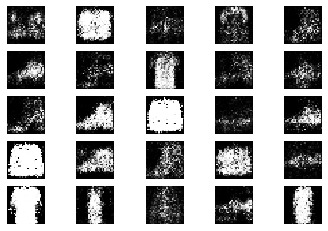

1001 [D loss: 0.381733, acc.: 81.25%] [G loss: 3.190330]
1002 [D loss: 0.304876, acc.: 89.06%] [G loss: 3.319125]
1003 [D loss: 0.450087, acc.: 85.94%] [G loss: 2.415541]
1004 [D loss: 0.468885, acc.: 78.12%] [G loss: 3.269627]
1005 [D loss: 0.431720, acc.: 81.25%] [G loss: 2.588390]
1006 [D loss: 0.278344, acc.: 90.62%] [G loss: 2.950830]
1007 [D loss: 0.376855, acc.: 87.50%] [G loss: 2.156219]
1008 [D loss: 0.462671, acc.: 73.44%] [G loss: 2.493735]
1009 [D loss: 0.417607, acc.: 79.69%] [G loss: 3.016024]
1010 [D loss: 0.439157, acc.: 75.00%] [G loss: 2.542784]
1011 [D loss: 0.336669, acc.: 82.81%] [G loss: 3.266595]
1012 [D loss: 0.429559, acc.: 81.25%] [G loss: 2.092540]
1013 [D loss: 0.340600, acc.: 89.06%] [G loss: 3.090890]
1014 [D loss: 0.347373, acc.: 87.50%] [G loss: 2.232195]
1015 [D loss: 0.369584, acc.: 81.25%] [G loss: 1.847949]
1016 [D loss: 0.314173, acc.: 84.38%] [G loss: 2.927182]
1017 [D loss: 0.341039, acc.: 89.06%] [G loss: 2.729990]
1018 [D loss: 0.349615, acc.: 8

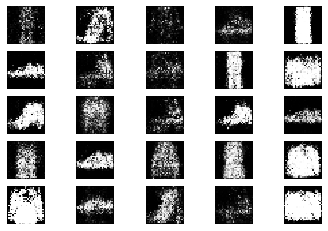

1201 [D loss: 0.437268, acc.: 82.81%] [G loss: 2.621824]
1202 [D loss: 0.422967, acc.: 76.56%] [G loss: 2.168122]
1203 [D loss: 0.337265, acc.: 89.06%] [G loss: 2.598739]
1204 [D loss: 0.563209, acc.: 73.44%] [G loss: 2.004794]
1205 [D loss: 0.231901, acc.: 92.19%] [G loss: 2.709613]
1206 [D loss: 0.340086, acc.: 78.12%] [G loss: 2.742733]
1207 [D loss: 0.278431, acc.: 90.62%] [G loss: 2.224236]
1208 [D loss: 0.442751, acc.: 81.25%] [G loss: 2.093761]
1209 [D loss: 0.324720, acc.: 82.81%] [G loss: 2.138263]
1210 [D loss: 0.287772, acc.: 89.06%] [G loss: 2.637145]
1211 [D loss: 0.303789, acc.: 87.50%] [G loss: 2.651300]
1212 [D loss: 0.427596, acc.: 78.12%] [G loss: 2.241483]
1213 [D loss: 0.276699, acc.: 84.38%] [G loss: 2.810941]
1214 [D loss: 0.392626, acc.: 89.06%] [G loss: 2.531131]
1215 [D loss: 0.388537, acc.: 84.38%] [G loss: 2.608446]
1216 [D loss: 0.283205, acc.: 90.62%] [G loss: 3.137078]
1217 [D loss: 0.585298, acc.: 71.88%] [G loss: 2.778313]
1218 [D loss: 0.297466, acc.: 8

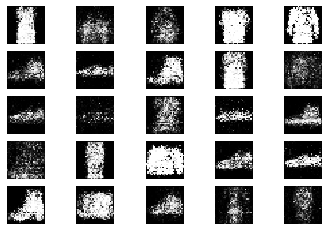

1401 [D loss: 0.219754, acc.: 93.75%] [G loss: 2.955882]
1402 [D loss: 0.575120, acc.: 70.31%] [G loss: 2.525859]
1403 [D loss: 0.377590, acc.: 81.25%] [G loss: 2.229784]
1404 [D loss: 0.591445, acc.: 70.31%] [G loss: 2.032129]
1405 [D loss: 0.423473, acc.: 79.69%] [G loss: 3.045288]
1406 [D loss: 0.491997, acc.: 71.88%] [G loss: 3.731708]
1407 [D loss: 0.375435, acc.: 87.50%] [G loss: 2.719923]
1408 [D loss: 0.437175, acc.: 79.69%] [G loss: 2.665844]
1409 [D loss: 0.228461, acc.: 90.62%] [G loss: 3.502643]
1410 [D loss: 0.423486, acc.: 82.81%] [G loss: 1.982117]
1411 [D loss: 0.360512, acc.: 81.25%] [G loss: 3.425287]
1412 [D loss: 0.367393, acc.: 81.25%] [G loss: 2.864657]
1413 [D loss: 0.461099, acc.: 79.69%] [G loss: 2.582190]
1414 [D loss: 0.253026, acc.: 92.19%] [G loss: 3.434981]
1415 [D loss: 0.293317, acc.: 85.94%] [G loss: 2.761715]
1416 [D loss: 0.389581, acc.: 79.69%] [G loss: 3.126572]
1417 [D loss: 0.229477, acc.: 93.75%] [G loss: 2.895918]
1418 [D loss: 0.775957, acc.: 6

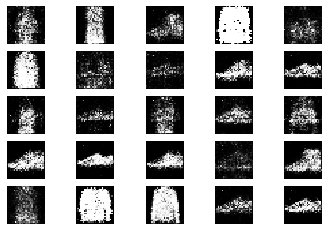

1601 [D loss: 0.329017, acc.: 89.06%] [G loss: 2.114283]
1602 [D loss: 0.453719, acc.: 73.44%] [G loss: 3.220903]
1603 [D loss: 0.403650, acc.: 78.12%] [G loss: 2.300289]
1604 [D loss: 0.279254, acc.: 84.38%] [G loss: 3.319576]
1605 [D loss: 0.303408, acc.: 85.94%] [G loss: 2.304648]
1606 [D loss: 0.398330, acc.: 82.81%] [G loss: 2.232190]
1607 [D loss: 0.366992, acc.: 82.81%] [G loss: 2.490901]
1608 [D loss: 0.403906, acc.: 82.81%] [G loss: 2.347205]
1609 [D loss: 0.314914, acc.: 89.06%] [G loss: 2.756917]
1610 [D loss: 0.246515, acc.: 90.62%] [G loss: 2.865819]
1611 [D loss: 0.660887, acc.: 62.50%] [G loss: 2.866606]
1612 [D loss: 0.937038, acc.: 56.25%] [G loss: 1.928289]
1613 [D loss: 0.489334, acc.: 75.00%] [G loss: 3.436800]
1614 [D loss: 0.416497, acc.: 78.12%] [G loss: 2.569073]
1615 [D loss: 0.479087, acc.: 81.25%] [G loss: 2.247332]
1616 [D loss: 0.400178, acc.: 81.25%] [G loss: 2.354711]
1617 [D loss: 0.350126, acc.: 85.94%] [G loss: 1.968408]
1618 [D loss: 0.408050, acc.: 7

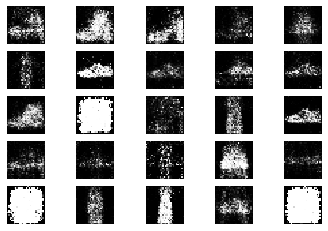

1801 [D loss: 0.287667, acc.: 89.06%] [G loss: 2.822798]
1802 [D loss: 0.483780, acc.: 71.88%] [G loss: 2.778319]
1803 [D loss: 0.209846, acc.: 93.75%] [G loss: 2.288299]
1804 [D loss: 0.242097, acc.: 89.06%] [G loss: 2.736139]
1805 [D loss: 0.307868, acc.: 90.62%] [G loss: 2.454504]
1806 [D loss: 0.279992, acc.: 85.94%] [G loss: 2.985715]
1807 [D loss: 0.390485, acc.: 82.81%] [G loss: 2.244919]
1808 [D loss: 0.528801, acc.: 76.56%] [G loss: 2.575621]
1809 [D loss: 0.486807, acc.: 78.12%] [G loss: 2.801844]
1810 [D loss: 0.537045, acc.: 70.31%] [G loss: 2.413165]
1811 [D loss: 0.567075, acc.: 76.56%] [G loss: 3.245718]
1812 [D loss: 0.423840, acc.: 81.25%] [G loss: 2.590405]
1813 [D loss: 0.313577, acc.: 84.38%] [G loss: 2.565021]
1814 [D loss: 0.469151, acc.: 76.56%] [G loss: 3.171014]
1815 [D loss: 0.259362, acc.: 84.38%] [G loss: 2.673579]
1816 [D loss: 0.300431, acc.: 90.62%] [G loss: 2.487644]
1817 [D loss: 0.345775, acc.: 85.94%] [G loss: 2.298891]
1818 [D loss: 0.431934, acc.: 7

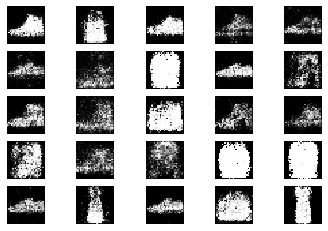

2001 [D loss: 0.274624, acc.: 89.06%] [G loss: 2.173834]
2002 [D loss: 0.361935, acc.: 81.25%] [G loss: 2.796711]
2003 [D loss: 0.371631, acc.: 87.50%] [G loss: 2.693686]
2004 [D loss: 0.424147, acc.: 81.25%] [G loss: 2.093911]
2005 [D loss: 0.461384, acc.: 75.00%] [G loss: 1.891416]
2006 [D loss: 0.436208, acc.: 78.12%] [G loss: 2.602272]
2007 [D loss: 0.263422, acc.: 92.19%] [G loss: 2.277970]
2008 [D loss: 0.520522, acc.: 75.00%] [G loss: 2.422478]
2009 [D loss: 0.680218, acc.: 64.06%] [G loss: 2.252890]
2010 [D loss: 0.335881, acc.: 81.25%] [G loss: 2.404006]
2011 [D loss: 0.450415, acc.: 76.56%] [G loss: 1.944288]
2012 [D loss: 0.349187, acc.: 82.81%] [G loss: 2.317270]
2013 [D loss: 0.304788, acc.: 89.06%] [G loss: 2.271018]
2014 [D loss: 0.370695, acc.: 82.81%] [G loss: 2.628462]
2015 [D loss: 0.294263, acc.: 89.06%] [G loss: 2.311662]
2016 [D loss: 0.442530, acc.: 78.12%] [G loss: 2.738134]
2017 [D loss: 0.355867, acc.: 84.38%] [G loss: 2.312797]
2018 [D loss: 0.379051, acc.: 8

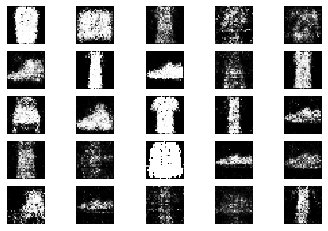

2201 [D loss: 0.361883, acc.: 81.25%] [G loss: 2.272006]
2202 [D loss: 0.332114, acc.: 85.94%] [G loss: 2.141428]
2203 [D loss: 0.344463, acc.: 78.12%] [G loss: 2.173728]
2204 [D loss: 0.375892, acc.: 85.94%] [G loss: 2.878700]
2205 [D loss: 0.528538, acc.: 71.88%] [G loss: 2.238101]
2206 [D loss: 0.423257, acc.: 76.56%] [G loss: 1.957685]
2207 [D loss: 0.373098, acc.: 84.38%] [G loss: 2.159686]
2208 [D loss: 0.387774, acc.: 85.94%] [G loss: 2.141266]
2209 [D loss: 0.246129, acc.: 90.62%] [G loss: 2.172448]
2210 [D loss: 0.414765, acc.: 81.25%] [G loss: 2.089154]
2211 [D loss: 0.379504, acc.: 87.50%] [G loss: 2.199874]
2212 [D loss: 0.330602, acc.: 82.81%] [G loss: 2.300848]
2213 [D loss: 0.410719, acc.: 82.81%] [G loss: 2.025320]
2214 [D loss: 0.377725, acc.: 82.81%] [G loss: 2.251355]
2215 [D loss: 0.329232, acc.: 90.62%] [G loss: 2.112089]
2216 [D loss: 0.385386, acc.: 81.25%] [G loss: 2.095215]
2217 [D loss: 0.412639, acc.: 81.25%] [G loss: 2.203690]
2218 [D loss: 0.351570, acc.: 8

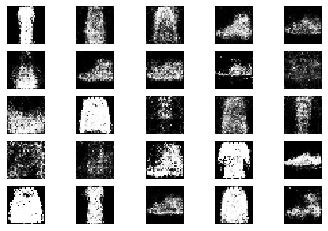

2401 [D loss: 0.345584, acc.: 90.62%] [G loss: 2.334277]
2402 [D loss: 0.390265, acc.: 78.12%] [G loss: 2.318845]
2403 [D loss: 0.233783, acc.: 92.19%] [G loss: 2.316726]
2404 [D loss: 0.598742, acc.: 73.44%] [G loss: 2.132779]
2405 [D loss: 0.465034, acc.: 73.44%] [G loss: 2.038476]
2406 [D loss: 0.398198, acc.: 75.00%] [G loss: 1.994599]
2407 [D loss: 0.405005, acc.: 81.25%] [G loss: 1.979414]
2408 [D loss: 0.310019, acc.: 85.94%] [G loss: 1.826853]
2409 [D loss: 0.306785, acc.: 90.62%] [G loss: 2.262292]
2410 [D loss: 0.315544, acc.: 84.38%] [G loss: 2.465112]
2411 [D loss: 0.351051, acc.: 85.94%] [G loss: 2.261937]
2412 [D loss: 0.283378, acc.: 89.06%] [G loss: 2.365425]
2413 [D loss: 0.343671, acc.: 84.38%] [G loss: 2.374394]
2414 [D loss: 0.335254, acc.: 84.38%] [G loss: 1.991260]
2415 [D loss: 0.463110, acc.: 76.56%] [G loss: 2.062101]
2416 [D loss: 0.280329, acc.: 85.94%] [G loss: 2.247002]
2417 [D loss: 0.483278, acc.: 79.69%] [G loss: 2.207685]
2418 [D loss: 0.670525, acc.: 7

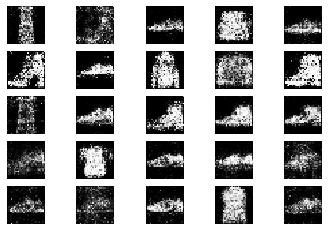

2601 [D loss: 0.273987, acc.: 92.19%] [G loss: 2.427696]
2602 [D loss: 0.216677, acc.: 89.06%] [G loss: 3.046739]
2603 [D loss: 0.308765, acc.: 84.38%] [G loss: 2.867528]
2604 [D loss: 0.345002, acc.: 85.94%] [G loss: 2.899924]
2605 [D loss: 0.261575, acc.: 92.19%] [G loss: 3.574754]
2606 [D loss: 0.491001, acc.: 73.44%] [G loss: 3.054585]
2607 [D loss: 0.411943, acc.: 87.50%] [G loss: 2.071801]
2608 [D loss: 0.371444, acc.: 81.25%] [G loss: 2.347082]
2609 [D loss: 0.321017, acc.: 85.94%] [G loss: 2.690592]
2610 [D loss: 0.282647, acc.: 89.06%] [G loss: 2.891552]
2611 [D loss: 0.473258, acc.: 79.69%] [G loss: 2.456720]
2612 [D loss: 0.427557, acc.: 82.81%] [G loss: 2.107351]
2613 [D loss: 0.404416, acc.: 79.69%] [G loss: 2.057739]
2614 [D loss: 0.251074, acc.: 87.50%] [G loss: 2.534750]
2615 [D loss: 0.508890, acc.: 78.12%] [G loss: 2.350765]
2616 [D loss: 0.318413, acc.: 84.38%] [G loss: 2.431017]
2617 [D loss: 0.343856, acc.: 82.81%] [G loss: 2.715548]
2618 [D loss: 0.414595, acc.: 8

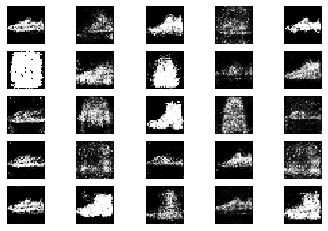

2801 [D loss: 0.454660, acc.: 78.12%] [G loss: 2.519484]
2802 [D loss: 0.571403, acc.: 76.56%] [G loss: 2.632188]
2803 [D loss: 0.397718, acc.: 82.81%] [G loss: 2.615999]
2804 [D loss: 0.357033, acc.: 82.81%] [G loss: 2.061460]
2805 [D loss: 0.161542, acc.: 96.88%] [G loss: 2.628322]
2806 [D loss: 0.483291, acc.: 73.44%] [G loss: 1.897947]
2807 [D loss: 0.417708, acc.: 76.56%] [G loss: 1.831407]
2808 [D loss: 0.371266, acc.: 82.81%] [G loss: 2.268695]
2809 [D loss: 0.308843, acc.: 90.62%] [G loss: 2.756675]
2810 [D loss: 0.342389, acc.: 85.94%] [G loss: 2.574960]
2811 [D loss: 0.440413, acc.: 81.25%] [G loss: 2.609657]
2812 [D loss: 0.319293, acc.: 89.06%] [G loss: 2.168888]
2813 [D loss: 0.404104, acc.: 85.94%] [G loss: 2.001926]
2814 [D loss: 0.355977, acc.: 84.38%] [G loss: 2.365371]
2815 [D loss: 0.478332, acc.: 82.81%] [G loss: 2.537300]
2816 [D loss: 0.325926, acc.: 84.38%] [G loss: 2.745743]
2817 [D loss: 0.417646, acc.: 82.81%] [G loss: 3.183515]
2818 [D loss: 0.346275, acc.: 8

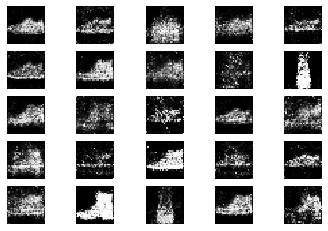

3001 [D loss: 0.429052, acc.: 81.25%] [G loss: 1.969644]
3002 [D loss: 0.297167, acc.: 85.94%] [G loss: 2.285200]
3003 [D loss: 0.291573, acc.: 89.06%] [G loss: 2.096097]
3004 [D loss: 0.398919, acc.: 81.25%] [G loss: 2.483661]
3005 [D loss: 0.425803, acc.: 81.25%] [G loss: 2.298598]
3006 [D loss: 0.429475, acc.: 76.56%] [G loss: 2.460693]
3007 [D loss: 0.394573, acc.: 81.25%] [G loss: 2.294421]
3008 [D loss: 0.321617, acc.: 90.62%] [G loss: 2.581992]
3009 [D loss: 0.354617, acc.: 85.94%] [G loss: 1.791273]
3010 [D loss: 0.340764, acc.: 82.81%] [G loss: 2.366060]
3011 [D loss: 0.407658, acc.: 82.81%] [G loss: 2.185937]
3012 [D loss: 0.338676, acc.: 87.50%] [G loss: 2.119593]
3013 [D loss: 0.447354, acc.: 81.25%] [G loss: 1.936611]
3014 [D loss: 0.350546, acc.: 87.50%] [G loss: 2.235822]
3015 [D loss: 0.401016, acc.: 81.25%] [G loss: 1.892864]
3016 [D loss: 0.333875, acc.: 89.06%] [G loss: 2.199955]
3017 [D loss: 0.354133, acc.: 87.50%] [G loss: 2.432626]
3018 [D loss: 0.296714, acc.: 8

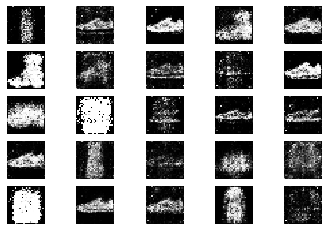

3201 [D loss: 0.406848, acc.: 79.69%] [G loss: 1.993926]
3202 [D loss: 0.406985, acc.: 79.69%] [G loss: 2.543167]
3203 [D loss: 0.424393, acc.: 81.25%] [G loss: 2.177213]
3204 [D loss: 0.319104, acc.: 89.06%] [G loss: 1.746711]
3205 [D loss: 0.359092, acc.: 81.25%] [G loss: 2.431472]
3206 [D loss: 0.289698, acc.: 90.62%] [G loss: 2.035835]
3207 [D loss: 0.507355, acc.: 82.81%] [G loss: 1.849890]
3208 [D loss: 0.257550, acc.: 90.62%] [G loss: 2.317465]
3209 [D loss: 0.314439, acc.: 85.94%] [G loss: 2.505132]
3210 [D loss: 0.369938, acc.: 84.38%] [G loss: 2.877898]
3211 [D loss: 0.595170, acc.: 76.56%] [G loss: 2.385394]
3212 [D loss: 0.311205, acc.: 87.50%] [G loss: 2.329480]
3213 [D loss: 0.411142, acc.: 79.69%] [G loss: 1.736380]
3214 [D loss: 0.533224, acc.: 82.81%] [G loss: 2.444393]
3215 [D loss: 0.602841, acc.: 70.31%] [G loss: 1.888632]
3216 [D loss: 0.416364, acc.: 81.25%] [G loss: 2.327129]
3217 [D loss: 0.264347, acc.: 90.62%] [G loss: 2.240076]
3218 [D loss: 0.384272, acc.: 8

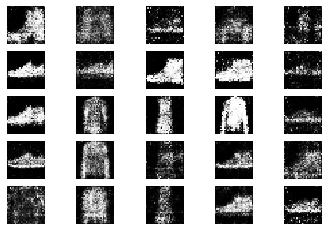

3401 [D loss: 0.359198, acc.: 87.50%] [G loss: 2.431638]
3402 [D loss: 0.374171, acc.: 84.38%] [G loss: 2.143134]
3403 [D loss: 0.447352, acc.: 79.69%] [G loss: 2.297174]
3404 [D loss: 0.482870, acc.: 76.56%] [G loss: 1.998179]
3405 [D loss: 0.431811, acc.: 75.00%] [G loss: 2.025597]
3406 [D loss: 0.413690, acc.: 79.69%] [G loss: 2.135863]
3407 [D loss: 0.525327, acc.: 75.00%] [G loss: 2.280953]
3408 [D loss: 0.477440, acc.: 78.12%] [G loss: 2.194664]
3409 [D loss: 0.388346, acc.: 82.81%] [G loss: 2.168641]
3410 [D loss: 0.481682, acc.: 81.25%] [G loss: 2.044428]
3411 [D loss: 0.230349, acc.: 93.75%] [G loss: 1.724622]
3412 [D loss: 0.260749, acc.: 93.75%] [G loss: 2.020662]
3413 [D loss: 0.394662, acc.: 84.38%] [G loss: 1.947842]
3414 [D loss: 0.308340, acc.: 85.94%] [G loss: 1.870759]
3415 [D loss: 0.457823, acc.: 79.69%] [G loss: 2.118448]
3416 [D loss: 0.349256, acc.: 84.38%] [G loss: 2.284633]
3417 [D loss: 0.395328, acc.: 84.38%] [G loss: 2.330895]
3418 [D loss: 0.303839, acc.: 8

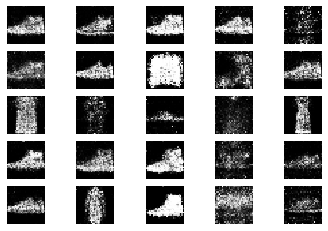

3601 [D loss: 0.204331, acc.: 92.19%] [G loss: 2.706202]
3602 [D loss: 0.467681, acc.: 78.12%] [G loss: 2.378977]
3603 [D loss: 0.401392, acc.: 78.12%] [G loss: 2.140110]
3604 [D loss: 0.434712, acc.: 79.69%] [G loss: 2.506639]
3605 [D loss: 0.350618, acc.: 81.25%] [G loss: 2.274450]
3606 [D loss: 0.303904, acc.: 89.06%] [G loss: 2.270883]
3607 [D loss: 0.379669, acc.: 84.38%] [G loss: 1.881617]
3608 [D loss: 0.349779, acc.: 82.81%] [G loss: 1.946664]
3609 [D loss: 0.265681, acc.: 90.62%] [G loss: 2.313895]
3610 [D loss: 0.546183, acc.: 75.00%] [G loss: 2.335248]
3611 [D loss: 0.466087, acc.: 73.44%] [G loss: 2.264195]
3612 [D loss: 0.332866, acc.: 85.94%] [G loss: 2.784844]
3613 [D loss: 0.340904, acc.: 84.38%] [G loss: 2.618035]
3614 [D loss: 0.370836, acc.: 79.69%] [G loss: 2.190134]
3615 [D loss: 0.437754, acc.: 79.69%] [G loss: 2.253247]
3616 [D loss: 0.276278, acc.: 90.62%] [G loss: 2.070589]
3617 [D loss: 0.466554, acc.: 82.81%] [G loss: 1.814191]
3618 [D loss: 0.361507, acc.: 8

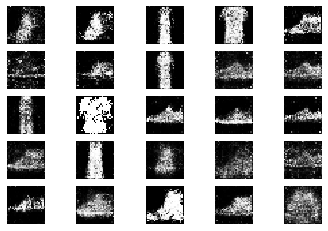

3801 [D loss: 0.269290, acc.: 93.75%] [G loss: 2.714157]
3802 [D loss: 0.278457, acc.: 90.62%] [G loss: 2.150271]
3803 [D loss: 0.442565, acc.: 82.81%] [G loss: 2.536912]
3804 [D loss: 0.329304, acc.: 89.06%] [G loss: 2.900242]
3805 [D loss: 0.446449, acc.: 79.69%] [G loss: 2.400578]
3806 [D loss: 0.397717, acc.: 82.81%] [G loss: 2.279177]
3807 [D loss: 0.408105, acc.: 78.12%] [G loss: 1.860337]
3808 [D loss: 0.387611, acc.: 78.12%] [G loss: 3.062821]
3809 [D loss: 0.351211, acc.: 81.25%] [G loss: 2.717406]
3810 [D loss: 0.557100, acc.: 75.00%] [G loss: 3.131938]
3811 [D loss: 0.274976, acc.: 87.50%] [G loss: 2.809122]
3812 [D loss: 0.401998, acc.: 82.81%] [G loss: 2.528961]
3813 [D loss: 0.391168, acc.: 81.25%] [G loss: 2.600785]
3814 [D loss: 0.348919, acc.: 87.50%] [G loss: 2.750534]
3815 [D loss: 0.231071, acc.: 92.19%] [G loss: 2.278623]
3816 [D loss: 0.435750, acc.: 78.12%] [G loss: 2.335871]
3817 [D loss: 0.415327, acc.: 82.81%] [G loss: 2.338837]
3818 [D loss: 0.395764, acc.: 8

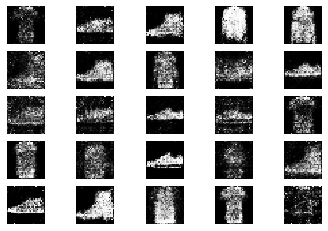

4001 [D loss: 0.400756, acc.: 84.38%] [G loss: 1.852432]
4002 [D loss: 0.399862, acc.: 85.94%] [G loss: 2.104450]
4003 [D loss: 0.336903, acc.: 90.62%] [G loss: 1.928095]
4004 [D loss: 0.477849, acc.: 76.56%] [G loss: 2.053415]
4005 [D loss: 0.375365, acc.: 85.94%] [G loss: 2.185320]
4006 [D loss: 0.335467, acc.: 87.50%] [G loss: 2.234544]
4007 [D loss: 0.356822, acc.: 81.25%] [G loss: 2.043958]
4008 [D loss: 0.636587, acc.: 62.50%] [G loss: 2.151350]
4009 [D loss: 0.406980, acc.: 81.25%] [G loss: 2.373681]
4010 [D loss: 0.467884, acc.: 79.69%] [G loss: 2.266988]
4011 [D loss: 0.358520, acc.: 81.25%] [G loss: 2.423082]
4012 [D loss: 0.384237, acc.: 78.12%] [G loss: 1.960363]
4013 [D loss: 0.374492, acc.: 82.81%] [G loss: 2.348001]
4014 [D loss: 0.378203, acc.: 81.25%] [G loss: 2.531586]
4015 [D loss: 0.579184, acc.: 71.88%] [G loss: 2.299329]
4016 [D loss: 0.441620, acc.: 85.94%] [G loss: 2.106949]
4017 [D loss: 0.402233, acc.: 85.94%] [G loss: 2.099690]
4018 [D loss: 0.540989, acc.: 7

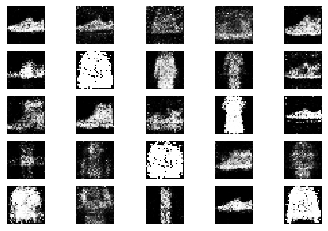

4201 [D loss: 0.427712, acc.: 76.56%] [G loss: 2.203206]
4202 [D loss: 0.263315, acc.: 89.06%] [G loss: 2.226626]
4203 [D loss: 0.334536, acc.: 81.25%] [G loss: 1.989518]
4204 [D loss: 0.294904, acc.: 87.50%] [G loss: 2.274339]
4205 [D loss: 0.424197, acc.: 84.38%] [G loss: 2.359675]
4206 [D loss: 0.298789, acc.: 87.50%] [G loss: 1.867573]
4207 [D loss: 0.529236, acc.: 78.12%] [G loss: 2.503106]
4208 [D loss: 0.478880, acc.: 78.12%] [G loss: 1.798323]
4209 [D loss: 0.447063, acc.: 84.38%] [G loss: 2.384501]
4210 [D loss: 0.443982, acc.: 82.81%] [G loss: 2.346567]
4211 [D loss: 0.337117, acc.: 84.38%] [G loss: 2.006665]
4212 [D loss: 0.252299, acc.: 90.62%] [G loss: 2.763575]
4213 [D loss: 0.331982, acc.: 84.38%] [G loss: 2.404375]
4214 [D loss: 0.346214, acc.: 90.62%] [G loss: 2.369394]
4215 [D loss: 0.453353, acc.: 78.12%] [G loss: 1.970882]
4216 [D loss: 0.261083, acc.: 92.19%] [G loss: 2.207251]
4217 [D loss: 0.352430, acc.: 84.38%] [G loss: 2.389020]
4218 [D loss: 0.418394, acc.: 7

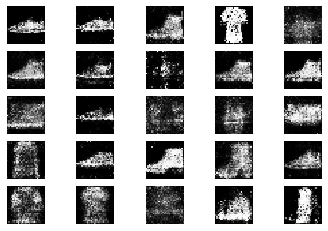

4401 [D loss: 0.441985, acc.: 78.12%] [G loss: 2.247527]
4402 [D loss: 0.377219, acc.: 85.94%] [G loss: 2.196682]
4403 [D loss: 0.346723, acc.: 85.94%] [G loss: 1.943217]
4404 [D loss: 0.409261, acc.: 81.25%] [G loss: 1.995012]
4405 [D loss: 0.473534, acc.: 76.56%] [G loss: 2.068696]
4406 [D loss: 0.548737, acc.: 75.00%] [G loss: 1.745849]
4407 [D loss: 0.322593, acc.: 87.50%] [G loss: 2.301893]
4408 [D loss: 0.498920, acc.: 73.44%] [G loss: 2.155132]
4409 [D loss: 0.289727, acc.: 89.06%] [G loss: 2.044536]
4410 [D loss: 0.277131, acc.: 89.06%] [G loss: 2.282194]
4411 [D loss: 0.363196, acc.: 82.81%] [G loss: 1.963867]
4412 [D loss: 0.366976, acc.: 81.25%] [G loss: 2.396458]
4413 [D loss: 0.487231, acc.: 75.00%] [G loss: 2.482697]
4414 [D loss: 0.296611, acc.: 89.06%] [G loss: 2.950074]
4415 [D loss: 0.491974, acc.: 76.56%] [G loss: 2.329623]
4416 [D loss: 0.520238, acc.: 71.88%] [G loss: 2.030468]
4417 [D loss: 0.475143, acc.: 82.81%] [G loss: 2.637589]
4418 [D loss: 0.418018, acc.: 8

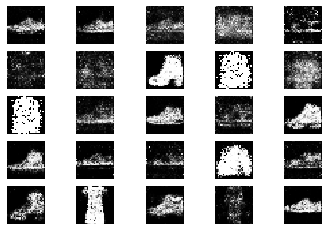

4601 [D loss: 0.475162, acc.: 82.81%] [G loss: 3.300832]
4602 [D loss: 0.262239, acc.: 89.06%] [G loss: 2.391372]
4603 [D loss: 0.296071, acc.: 87.50%] [G loss: 2.117942]
4604 [D loss: 0.266232, acc.: 85.94%] [G loss: 2.757350]
4605 [D loss: 0.387467, acc.: 81.25%] [G loss: 2.319373]
4606 [D loss: 0.427856, acc.: 81.25%] [G loss: 2.425383]
4607 [D loss: 0.346117, acc.: 84.38%] [G loss: 2.149367]
4608 [D loss: 0.543725, acc.: 76.56%] [G loss: 2.820403]
4609 [D loss: 0.229793, acc.: 90.62%] [G loss: 2.658149]
4610 [D loss: 0.359683, acc.: 84.38%] [G loss: 2.686522]
4611 [D loss: 0.338812, acc.: 89.06%] [G loss: 1.892982]
4612 [D loss: 0.485084, acc.: 79.69%] [G loss: 2.139277]
4613 [D loss: 0.295292, acc.: 89.06%] [G loss: 2.362273]
4614 [D loss: 0.484497, acc.: 76.56%] [G loss: 2.353225]
4615 [D loss: 0.303165, acc.: 85.94%] [G loss: 2.335847]
4616 [D loss: 0.509143, acc.: 76.56%] [G loss: 2.171868]
4617 [D loss: 0.266114, acc.: 93.75%] [G loss: 2.494059]
4618 [D loss: 0.332130, acc.: 8

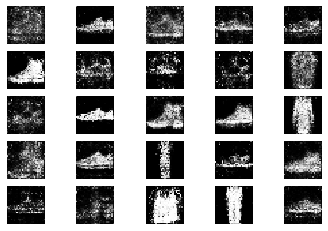

4801 [D loss: 0.347763, acc.: 82.81%] [G loss: 2.501012]
4802 [D loss: 0.433828, acc.: 82.81%] [G loss: 2.098463]
4803 [D loss: 0.326048, acc.: 89.06%] [G loss: 2.304207]
4804 [D loss: 0.399244, acc.: 79.69%] [G loss: 1.976422]
4805 [D loss: 0.353354, acc.: 79.69%] [G loss: 1.988091]
4806 [D loss: 0.316973, acc.: 84.38%] [G loss: 2.078705]
4807 [D loss: 0.289108, acc.: 90.62%] [G loss: 2.128089]
4808 [D loss: 0.269316, acc.: 92.19%] [G loss: 2.163802]
4809 [D loss: 0.486645, acc.: 76.56%] [G loss: 1.941718]
4810 [D loss: 0.396962, acc.: 81.25%] [G loss: 2.199605]
4811 [D loss: 0.293871, acc.: 84.38%] [G loss: 2.058079]
4812 [D loss: 0.399830, acc.: 81.25%] [G loss: 2.190863]
4813 [D loss: 0.277816, acc.: 85.94%] [G loss: 2.392754]
4814 [D loss: 0.414538, acc.: 79.69%] [G loss: 1.909633]
4815 [D loss: 0.440434, acc.: 79.69%] [G loss: 2.094698]
4816 [D loss: 0.371734, acc.: 87.50%] [G loss: 1.982776]
4817 [D loss: 0.331068, acc.: 87.50%] [G loss: 2.053843]
4818 [D loss: 0.436887, acc.: 8

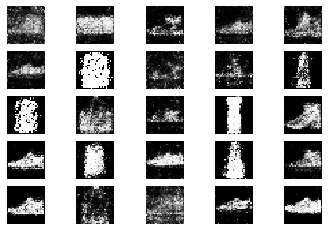

5001 [D loss: 0.361959, acc.: 81.25%] [G loss: 2.208547]
5002 [D loss: 0.330440, acc.: 87.50%] [G loss: 1.688806]
5003 [D loss: 0.591074, acc.: 70.31%] [G loss: 1.574964]
5004 [D loss: 0.322936, acc.: 87.50%] [G loss: 1.973810]
5005 [D loss: 0.248690, acc.: 90.62%] [G loss: 1.751031]
5006 [D loss: 0.290058, acc.: 87.50%] [G loss: 1.781819]
5007 [D loss: 0.597233, acc.: 70.31%] [G loss: 1.998586]
5008 [D loss: 0.392321, acc.: 84.38%] [G loss: 1.927744]
5009 [D loss: 0.333046, acc.: 90.62%] [G loss: 1.916906]
5010 [D loss: 0.360495, acc.: 81.25%] [G loss: 1.974612]
5011 [D loss: 0.351680, acc.: 87.50%] [G loss: 2.296810]
5012 [D loss: 0.309431, acc.: 87.50%] [G loss: 2.140099]
5013 [D loss: 0.397023, acc.: 85.94%] [G loss: 1.963633]
5014 [D loss: 0.305949, acc.: 84.38%] [G loss: 1.941572]
5015 [D loss: 0.402301, acc.: 82.81%] [G loss: 1.934321]
5016 [D loss: 0.469099, acc.: 79.69%] [G loss: 1.943733]
5017 [D loss: 0.467818, acc.: 76.56%] [G loss: 2.138000]
5018 [D loss: 0.429886, acc.: 7

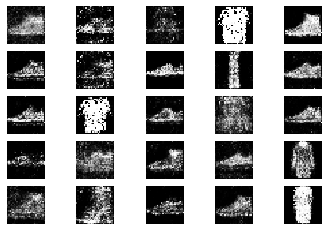

5201 [D loss: 0.347327, acc.: 84.38%] [G loss: 2.151678]
5202 [D loss: 0.443672, acc.: 81.25%] [G loss: 1.878233]
5203 [D loss: 0.256928, acc.: 93.75%] [G loss: 1.699204]
5204 [D loss: 0.435991, acc.: 79.69%] [G loss: 1.735189]
5205 [D loss: 0.412274, acc.: 81.25%] [G loss: 2.080038]
5206 [D loss: 0.540697, acc.: 73.44%] [G loss: 2.326813]
5207 [D loss: 0.332958, acc.: 82.81%] [G loss: 2.088728]
5208 [D loss: 0.383705, acc.: 84.38%] [G loss: 1.957629]
5209 [D loss: 0.227461, acc.: 92.19%] [G loss: 2.251777]
5210 [D loss: 0.459046, acc.: 82.81%] [G loss: 1.994347]
5211 [D loss: 0.317158, acc.: 85.94%] [G loss: 2.071946]
5212 [D loss: 0.478683, acc.: 82.81%] [G loss: 2.017695]
5213 [D loss: 0.460402, acc.: 76.56%] [G loss: 2.446815]
5214 [D loss: 0.496555, acc.: 76.56%] [G loss: 1.644412]
5215 [D loss: 0.332957, acc.: 87.50%] [G loss: 2.285348]
5216 [D loss: 0.389196, acc.: 81.25%] [G loss: 2.146046]
5217 [D loss: 0.434899, acc.: 82.81%] [G loss: 1.923682]
5218 [D loss: 0.424258, acc.: 8

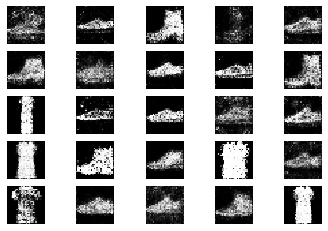

5401 [D loss: 0.383285, acc.: 82.81%] [G loss: 2.676353]
5402 [D loss: 0.326180, acc.: 79.69%] [G loss: 2.824138]
5403 [D loss: 0.292391, acc.: 84.38%] [G loss: 2.304036]
5404 [D loss: 0.340981, acc.: 89.06%] [G loss: 2.361122]
5405 [D loss: 0.297830, acc.: 82.81%] [G loss: 2.812380]
5406 [D loss: 0.318932, acc.: 89.06%] [G loss: 2.389284]
5407 [D loss: 0.574641, acc.: 68.75%] [G loss: 2.170407]
5408 [D loss: 0.314908, acc.: 87.50%] [G loss: 2.542471]
5409 [D loss: 0.398990, acc.: 82.81%] [G loss: 1.914191]
5410 [D loss: 0.389332, acc.: 85.94%] [G loss: 2.399353]
5411 [D loss: 0.300655, acc.: 89.06%] [G loss: 2.165473]
5412 [D loss: 0.319788, acc.: 84.38%] [G loss: 2.317514]
5413 [D loss: 0.476076, acc.: 75.00%] [G loss: 1.865722]
5414 [D loss: 0.304574, acc.: 87.50%] [G loss: 2.116749]
5415 [D loss: 0.208952, acc.: 92.19%] [G loss: 2.252988]
5416 [D loss: 0.370162, acc.: 82.81%] [G loss: 2.116674]
5417 [D loss: 0.662896, acc.: 70.31%] [G loss: 1.771684]
5418 [D loss: 0.455774, acc.: 7

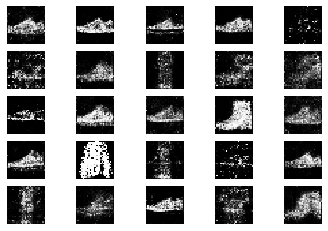

5601 [D loss: 0.324386, acc.: 85.94%] [G loss: 2.061163]
5602 [D loss: 0.247751, acc.: 93.75%] [G loss: 3.753845]
5603 [D loss: 0.261858, acc.: 90.62%] [G loss: 2.832591]
5604 [D loss: 0.407922, acc.: 79.69%] [G loss: 2.627493]
5605 [D loss: 0.329897, acc.: 85.94%] [G loss: 2.543500]
5606 [D loss: 0.274252, acc.: 90.62%] [G loss: 2.356657]
5607 [D loss: 0.336931, acc.: 81.25%] [G loss: 2.335760]
5608 [D loss: 0.296665, acc.: 84.38%] [G loss: 2.295383]
5609 [D loss: 0.360074, acc.: 87.50%] [G loss: 2.509426]
5610 [D loss: 0.290071, acc.: 90.62%] [G loss: 1.943047]
5611 [D loss: 0.267640, acc.: 89.06%] [G loss: 2.229064]
5612 [D loss: 0.284681, acc.: 90.62%] [G loss: 2.252400]
5613 [D loss: 0.595593, acc.: 75.00%] [G loss: 2.403459]
5614 [D loss: 0.298960, acc.: 87.50%] [G loss: 2.306991]
5615 [D loss: 0.329107, acc.: 89.06%] [G loss: 2.064270]
5616 [D loss: 0.238524, acc.: 89.06%] [G loss: 2.554570]
5617 [D loss: 0.369229, acc.: 84.38%] [G loss: 2.346092]
5618 [D loss: 0.352167, acc.: 8

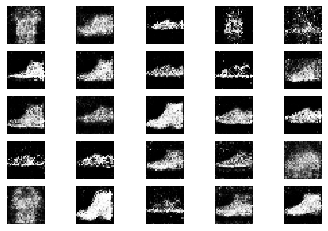

5801 [D loss: 0.312313, acc.: 84.38%] [G loss: 1.850250]
5802 [D loss: 0.518714, acc.: 78.12%] [G loss: 2.346363]
5803 [D loss: 0.315459, acc.: 84.38%] [G loss: 2.275971]
5804 [D loss: 0.492086, acc.: 78.12%] [G loss: 1.789053]
5805 [D loss: 0.457807, acc.: 75.00%] [G loss: 1.912734]
5806 [D loss: 0.473061, acc.: 76.56%] [G loss: 1.895103]
5807 [D loss: 0.427999, acc.: 79.69%] [G loss: 1.905846]
5808 [D loss: 0.286500, acc.: 85.94%] [G loss: 2.036485]
5809 [D loss: 0.283991, acc.: 89.06%] [G loss: 1.837596]
5810 [D loss: 0.377003, acc.: 84.38%] [G loss: 1.888327]
5811 [D loss: 0.315364, acc.: 84.38%] [G loss: 2.115438]
5812 [D loss: 0.393122, acc.: 81.25%] [G loss: 2.006929]
5813 [D loss: 0.365984, acc.: 84.38%] [G loss: 2.251840]
5814 [D loss: 0.460252, acc.: 81.25%] [G loss: 2.486534]
5815 [D loss: 0.315924, acc.: 87.50%] [G loss: 2.122258]
5816 [D loss: 0.372499, acc.: 87.50%] [G loss: 1.867341]
5817 [D loss: 0.308728, acc.: 84.38%] [G loss: 2.759200]
5818 [D loss: 0.372165, acc.: 8

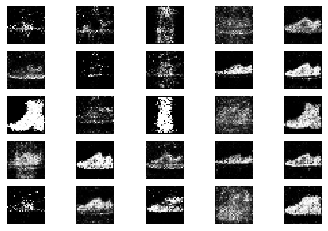

6001 [D loss: 0.379242, acc.: 85.94%] [G loss: 2.152747]
6002 [D loss: 0.483882, acc.: 81.25%] [G loss: 2.705032]
6003 [D loss: 0.483821, acc.: 82.81%] [G loss: 2.104767]
6004 [D loss: 0.384028, acc.: 84.38%] [G loss: 1.976984]
6005 [D loss: 0.292104, acc.: 90.62%] [G loss: 2.468248]
6006 [D loss: 0.607857, acc.: 67.19%] [G loss: 1.963116]
6007 [D loss: 0.357174, acc.: 87.50%] [G loss: 2.113538]
6008 [D loss: 0.273740, acc.: 87.50%] [G loss: 2.676933]
6009 [D loss: 0.364021, acc.: 82.81%] [G loss: 1.653804]
6010 [D loss: 0.229333, acc.: 93.75%] [G loss: 2.182699]
6011 [D loss: 0.209714, acc.: 93.75%] [G loss: 1.771218]
6012 [D loss: 0.383103, acc.: 82.81%] [G loss: 2.296181]
6013 [D loss: 0.266756, acc.: 87.50%] [G loss: 2.326844]
6014 [D loss: 0.616898, acc.: 76.56%] [G loss: 2.262831]
6015 [D loss: 0.289230, acc.: 89.06%] [G loss: 2.354232]
6016 [D loss: 0.307082, acc.: 89.06%] [G loss: 1.902213]
6017 [D loss: 0.349763, acc.: 84.38%] [G loss: 2.622173]
6018 [D loss: 0.414936, acc.: 8

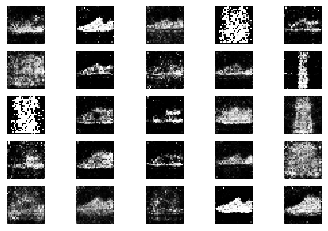

6201 [D loss: 0.340557, acc.: 84.38%] [G loss: 2.122809]
6202 [D loss: 0.314212, acc.: 85.94%] [G loss: 1.871115]
6203 [D loss: 0.352596, acc.: 87.50%] [G loss: 2.107674]
6204 [D loss: 0.357408, acc.: 84.38%] [G loss: 2.100210]
6205 [D loss: 0.309492, acc.: 89.06%] [G loss: 2.230416]
6206 [D loss: 0.448944, acc.: 81.25%] [G loss: 2.533202]
6207 [D loss: 0.292360, acc.: 89.06%] [G loss: 2.493130]
6208 [D loss: 0.341310, acc.: 82.81%] [G loss: 2.497504]
6209 [D loss: 0.342120, acc.: 85.94%] [G loss: 1.981812]
6210 [D loss: 0.373645, acc.: 84.38%] [G loss: 2.100525]
6211 [D loss: 0.309079, acc.: 87.50%] [G loss: 2.112628]
6212 [D loss: 0.477143, acc.: 76.56%] [G loss: 1.742614]
6213 [D loss: 0.452917, acc.: 79.69%] [G loss: 1.936913]
6214 [D loss: 0.354733, acc.: 85.94%] [G loss: 1.690990]
6215 [D loss: 0.324033, acc.: 89.06%] [G loss: 1.900811]
6216 [D loss: 0.294089, acc.: 90.62%] [G loss: 1.770070]
6217 [D loss: 0.523021, acc.: 73.44%] [G loss: 1.905830]
6218 [D loss: 0.232635, acc.: 9

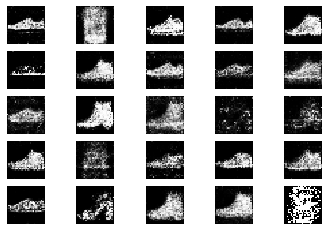

6401 [D loss: 0.482761, acc.: 82.81%] [G loss: 2.610270]
6402 [D loss: 0.276152, acc.: 90.62%] [G loss: 1.839789]
6403 [D loss: 0.240672, acc.: 92.19%] [G loss: 1.905835]
6404 [D loss: 0.379993, acc.: 84.38%] [G loss: 1.982111]
6405 [D loss: 0.172708, acc.: 93.75%] [G loss: 2.269129]
6406 [D loss: 0.327891, acc.: 85.94%] [G loss: 2.202770]
6407 [D loss: 0.438003, acc.: 81.25%] [G loss: 2.344921]
6408 [D loss: 0.277745, acc.: 90.62%] [G loss: 2.279021]
6409 [D loss: 0.275099, acc.: 92.19%] [G loss: 1.989217]
6410 [D loss: 0.314612, acc.: 84.38%] [G loss: 2.203959]
6411 [D loss: 0.404949, acc.: 82.81%] [G loss: 2.018795]
6412 [D loss: 0.258560, acc.: 90.62%] [G loss: 2.500703]
6413 [D loss: 0.160615, acc.: 95.31%] [G loss: 2.904337]
6414 [D loss: 0.510994, acc.: 78.12%] [G loss: 2.293231]
6415 [D loss: 0.441128, acc.: 81.25%] [G loss: 2.211654]
6416 [D loss: 0.403610, acc.: 84.38%] [G loss: 1.885435]
6417 [D loss: 0.425972, acc.: 79.69%] [G loss: 2.007519]
6418 [D loss: 0.356303, acc.: 8

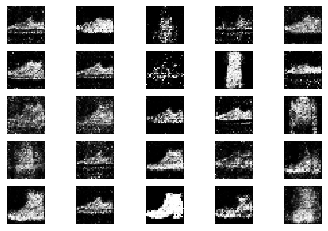

6601 [D loss: 0.407290, acc.: 81.25%] [G loss: 2.069440]
6602 [D loss: 0.324811, acc.: 85.94%] [G loss: 1.910403]
6603 [D loss: 0.357099, acc.: 84.38%] [G loss: 2.450232]
6604 [D loss: 0.340267, acc.: 85.94%] [G loss: 2.178117]
6605 [D loss: 0.460470, acc.: 85.94%] [G loss: 1.817786]
6606 [D loss: 0.324436, acc.: 84.38%] [G loss: 1.955613]
6607 [D loss: 0.314203, acc.: 85.94%] [G loss: 2.025623]
6608 [D loss: 0.341404, acc.: 85.94%] [G loss: 1.991077]
6609 [D loss: 0.373942, acc.: 82.81%] [G loss: 2.071465]
6610 [D loss: 0.309095, acc.: 89.06%] [G loss: 1.804091]
6611 [D loss: 0.378468, acc.: 81.25%] [G loss: 1.520668]
6612 [D loss: 0.362738, acc.: 84.38%] [G loss: 1.889903]
6613 [D loss: 0.360543, acc.: 82.81%] [G loss: 2.022744]
6614 [D loss: 0.416426, acc.: 82.81%] [G loss: 1.898255]
6615 [D loss: 0.207809, acc.: 93.75%] [G loss: 2.007426]
6616 [D loss: 0.256001, acc.: 87.50%] [G loss: 1.783674]
6617 [D loss: 0.394710, acc.: 81.25%] [G loss: 1.903268]
6618 [D loss: 0.421730, acc.: 8

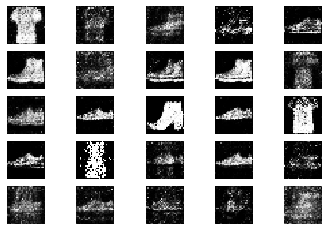

6801 [D loss: 0.309543, acc.: 87.50%] [G loss: 1.917268]
6802 [D loss: 0.315053, acc.: 87.50%] [G loss: 1.937138]
6803 [D loss: 0.336566, acc.: 85.94%] [G loss: 1.901784]
6804 [D loss: 0.293892, acc.: 89.06%] [G loss: 1.973335]
6805 [D loss: 0.331803, acc.: 90.62%] [G loss: 1.995441]
6806 [D loss: 0.316217, acc.: 85.94%] [G loss: 2.502265]
6807 [D loss: 0.447025, acc.: 76.56%] [G loss: 2.289972]
6808 [D loss: 0.290700, acc.: 90.62%] [G loss: 2.151912]
6809 [D loss: 0.408879, acc.: 85.94%] [G loss: 2.310632]
6810 [D loss: 0.429899, acc.: 84.38%] [G loss: 2.107733]
6811 [D loss: 0.352704, acc.: 84.38%] [G loss: 2.434833]
6812 [D loss: 0.343751, acc.: 87.50%] [G loss: 2.264138]
6813 [D loss: 0.515793, acc.: 75.00%] [G loss: 1.764593]
6814 [D loss: 0.438233, acc.: 78.12%] [G loss: 1.990612]
6815 [D loss: 0.349184, acc.: 84.38%] [G loss: 2.081154]
6816 [D loss: 0.306940, acc.: 85.94%] [G loss: 2.089974]
6817 [D loss: 0.293233, acc.: 92.19%] [G loss: 2.316213]
6818 [D loss: 0.383956, acc.: 7

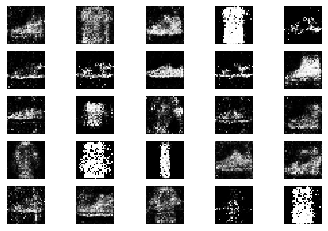

7001 [D loss: 0.302422, acc.: 90.62%] [G loss: 2.104071]
7002 [D loss: 0.445551, acc.: 78.12%] [G loss: 1.794653]
7003 [D loss: 0.433025, acc.: 82.81%] [G loss: 1.872454]
7004 [D loss: 0.378645, acc.: 84.38%] [G loss: 1.816565]
7005 [D loss: 0.442537, acc.: 82.81%] [G loss: 2.204453]
7006 [D loss: 0.413272, acc.: 81.25%] [G loss: 1.805109]
7007 [D loss: 0.384788, acc.: 82.81%] [G loss: 2.027721]
7008 [D loss: 0.399717, acc.: 81.25%] [G loss: 1.845479]
7009 [D loss: 0.321579, acc.: 89.06%] [G loss: 2.054208]
7010 [D loss: 0.291023, acc.: 85.94%] [G loss: 1.993901]
7011 [D loss: 0.418219, acc.: 81.25%] [G loss: 2.152490]
7012 [D loss: 0.367188, acc.: 81.25%] [G loss: 2.465676]
7013 [D loss: 0.446342, acc.: 76.56%] [G loss: 1.985329]
7014 [D loss: 0.471982, acc.: 75.00%] [G loss: 1.736294]
7015 [D loss: 0.305288, acc.: 87.50%] [G loss: 1.745489]
7016 [D loss: 0.234663, acc.: 90.62%] [G loss: 1.844197]
7017 [D loss: 0.417132, acc.: 81.25%] [G loss: 1.955853]
7018 [D loss: 0.362555, acc.: 8

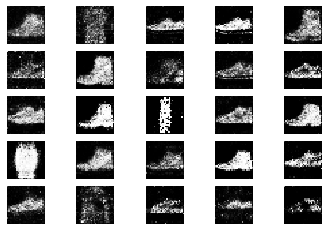

7201 [D loss: 0.451215, acc.: 79.69%] [G loss: 1.925435]
7202 [D loss: 0.282396, acc.: 85.94%] [G loss: 2.219641]
7203 [D loss: 0.285478, acc.: 89.06%] [G loss: 2.195526]
7204 [D loss: 0.344818, acc.: 85.94%] [G loss: 1.969487]
7205 [D loss: 0.410011, acc.: 78.12%] [G loss: 1.923504]
7206 [D loss: 0.237714, acc.: 92.19%] [G loss: 2.047338]
7207 [D loss: 0.387418, acc.: 84.38%] [G loss: 1.932375]
7208 [D loss: 0.468768, acc.: 81.25%] [G loss: 2.147657]
7209 [D loss: 0.354349, acc.: 85.94%] [G loss: 1.888453]
7210 [D loss: 0.351640, acc.: 89.06%] [G loss: 1.987817]
7211 [D loss: 0.336062, acc.: 84.38%] [G loss: 2.304374]
7212 [D loss: 0.423259, acc.: 81.25%] [G loss: 2.155102]
7213 [D loss: 0.541521, acc.: 79.69%] [G loss: 1.970934]
7214 [D loss: 0.282344, acc.: 90.62%] [G loss: 2.016690]
7215 [D loss: 0.279202, acc.: 84.38%] [G loss: 2.078660]
7216 [D loss: 0.363890, acc.: 81.25%] [G loss: 1.912700]
7217 [D loss: 0.219184, acc.: 90.62%] [G loss: 1.959369]
7218 [D loss: 0.368686, acc.: 8

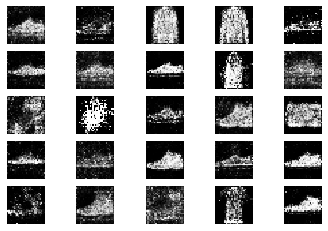

7401 [D loss: 0.370856, acc.: 87.50%] [G loss: 2.642045]
7402 [D loss: 0.434769, acc.: 76.56%] [G loss: 2.098601]
7403 [D loss: 0.302005, acc.: 92.19%] [G loss: 1.991632]
7404 [D loss: 0.272848, acc.: 90.62%] [G loss: 2.101202]
7405 [D loss: 0.462810, acc.: 76.56%] [G loss: 2.298529]
7406 [D loss: 0.365521, acc.: 78.12%] [G loss: 1.768299]
7407 [D loss: 0.389431, acc.: 79.69%] [G loss: 1.807441]
7408 [D loss: 0.310885, acc.: 85.94%] [G loss: 2.017286]
7409 [D loss: 0.628748, acc.: 73.44%] [G loss: 1.558309]
7410 [D loss: 0.402359, acc.: 79.69%] [G loss: 1.925449]
7411 [D loss: 0.301232, acc.: 87.50%] [G loss: 2.154387]
7412 [D loss: 0.318847, acc.: 85.94%] [G loss: 1.880676]
7413 [D loss: 0.255289, acc.: 90.62%] [G loss: 2.326203]
7414 [D loss: 0.306170, acc.: 89.06%] [G loss: 1.879659]
7415 [D loss: 0.324253, acc.: 87.50%] [G loss: 2.128344]
7416 [D loss: 0.356746, acc.: 84.38%] [G loss: 2.285371]
7417 [D loss: 0.406978, acc.: 75.00%] [G loss: 1.935023]
7418 [D loss: 0.341501, acc.: 8

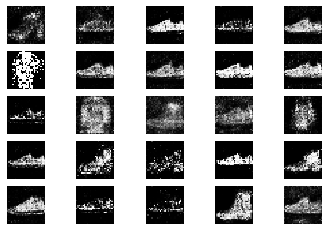

7601 [D loss: 0.395086, acc.: 84.38%] [G loss: 2.457559]
7602 [D loss: 0.340239, acc.: 85.94%] [G loss: 2.585449]
7603 [D loss: 0.517560, acc.: 75.00%] [G loss: 2.354235]
7604 [D loss: 0.269521, acc.: 84.38%] [G loss: 2.296660]
7605 [D loss: 0.390260, acc.: 82.81%] [G loss: 2.115268]
7606 [D loss: 0.320523, acc.: 84.38%] [G loss: 2.063591]
7607 [D loss: 0.445327, acc.: 76.56%] [G loss: 2.457425]
7608 [D loss: 0.383484, acc.: 82.81%] [G loss: 2.268338]
7609 [D loss: 0.423968, acc.: 81.25%] [G loss: 2.672269]
7610 [D loss: 0.184958, acc.: 90.62%] [G loss: 2.553403]
7611 [D loss: 0.462470, acc.: 76.56%] [G loss: 3.253461]
7612 [D loss: 0.426399, acc.: 79.69%] [G loss: 2.482587]
7613 [D loss: 0.290295, acc.: 90.62%] [G loss: 1.709441]
7614 [D loss: 0.252451, acc.: 92.19%] [G loss: 2.808964]
7615 [D loss: 0.219769, acc.: 92.19%] [G loss: 2.807730]
7616 [D loss: 0.409233, acc.: 79.69%] [G loss: 2.609153]
7617 [D loss: 0.536920, acc.: 79.69%] [G loss: 2.377131]
7618 [D loss: 0.174086, acc.: 9

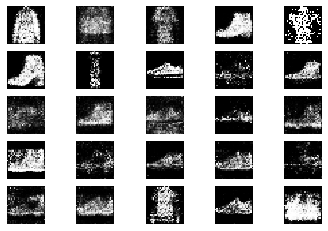

7801 [D loss: 0.383099, acc.: 82.81%] [G loss: 1.951079]
7802 [D loss: 0.361246, acc.: 82.81%] [G loss: 2.220279]
7803 [D loss: 0.240395, acc.: 90.62%] [G loss: 2.360948]
7804 [D loss: 0.284722, acc.: 90.62%] [G loss: 2.449116]
7805 [D loss: 0.458034, acc.: 79.69%] [G loss: 2.929503]
7806 [D loss: 0.286569, acc.: 85.94%] [G loss: 2.739638]
7807 [D loss: 0.250562, acc.: 92.19%] [G loss: 2.534237]
7808 [D loss: 0.207443, acc.: 89.06%] [G loss: 2.316684]
7809 [D loss: 0.418387, acc.: 81.25%] [G loss: 2.107618]
7810 [D loss: 0.313774, acc.: 87.50%] [G loss: 2.143916]
7811 [D loss: 0.392882, acc.: 82.81%] [G loss: 2.216890]
7812 [D loss: 0.508329, acc.: 76.56%] [G loss: 2.029741]
7813 [D loss: 0.465609, acc.: 84.38%] [G loss: 2.369152]
7814 [D loss: 0.346452, acc.: 82.81%] [G loss: 2.285988]
7815 [D loss: 0.388915, acc.: 87.50%] [G loss: 2.088391]
7816 [D loss: 0.249348, acc.: 90.62%] [G loss: 2.374654]
7817 [D loss: 0.261309, acc.: 93.75%] [G loss: 2.366449]
7818 [D loss: 0.353452, acc.: 8

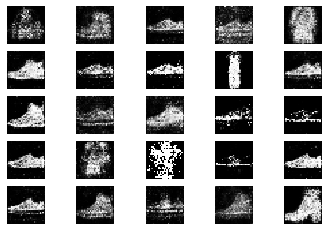

8001 [D loss: 0.286962, acc.: 87.50%] [G loss: 2.600605]
8002 [D loss: 0.338903, acc.: 89.06%] [G loss: 2.636922]
8003 [D loss: 0.249222, acc.: 90.62%] [G loss: 2.679450]
8004 [D loss: 0.335377, acc.: 87.50%] [G loss: 2.252982]
8005 [D loss: 0.210489, acc.: 92.19%] [G loss: 3.064022]
8006 [D loss: 0.283000, acc.: 87.50%] [G loss: 2.247017]
8007 [D loss: 0.342223, acc.: 85.94%] [G loss: 3.198984]
8008 [D loss: 0.486400, acc.: 81.25%] [G loss: 1.739953]
8009 [D loss: 0.385218, acc.: 84.38%] [G loss: 2.050750]
8010 [D loss: 0.383016, acc.: 85.94%] [G loss: 2.377940]
8011 [D loss: 0.436569, acc.: 84.38%] [G loss: 2.066031]
8012 [D loss: 0.252817, acc.: 89.06%] [G loss: 2.661616]
8013 [D loss: 0.305094, acc.: 84.38%] [G loss: 1.927726]
8014 [D loss: 0.262804, acc.: 87.50%] [G loss: 2.150734]
8015 [D loss: 0.447697, acc.: 76.56%] [G loss: 2.254874]
8016 [D loss: 0.305273, acc.: 85.94%] [G loss: 2.000654]
8017 [D loss: 0.264854, acc.: 92.19%] [G loss: 2.643798]
8018 [D loss: 0.406603, acc.: 8

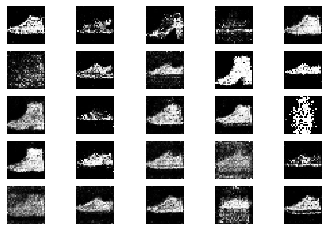

8201 [D loss: 0.312568, acc.: 84.38%] [G loss: 2.030402]
8202 [D loss: 0.314117, acc.: 87.50%] [G loss: 2.178314]
8203 [D loss: 0.483731, acc.: 79.69%] [G loss: 2.352470]
8204 [D loss: 0.372990, acc.: 82.81%] [G loss: 2.078004]
8205 [D loss: 0.470641, acc.: 78.12%] [G loss: 2.110457]
8206 [D loss: 0.400814, acc.: 82.81%] [G loss: 1.736215]
8207 [D loss: 0.307581, acc.: 85.94%] [G loss: 2.234646]
8208 [D loss: 0.177593, acc.: 95.31%] [G loss: 2.257602]
8209 [D loss: 0.389911, acc.: 84.38%] [G loss: 2.365746]
8210 [D loss: 0.421703, acc.: 84.38%] [G loss: 2.109734]
8211 [D loss: 0.341818, acc.: 82.81%] [G loss: 1.695689]
8212 [D loss: 0.267452, acc.: 89.06%] [G loss: 2.125596]
8213 [D loss: 0.515368, acc.: 71.88%] [G loss: 1.800047]
8214 [D loss: 0.366526, acc.: 84.38%] [G loss: 1.860394]
8215 [D loss: 0.463504, acc.: 81.25%] [G loss: 2.079031]
8216 [D loss: 0.355581, acc.: 82.81%] [G loss: 2.167991]
8217 [D loss: 0.290513, acc.: 89.06%] [G loss: 2.123739]
8218 [D loss: 0.266852, acc.: 8

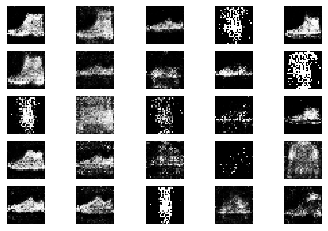

8401 [D loss: 0.232591, acc.: 92.19%] [G loss: 2.281532]
8402 [D loss: 0.347680, acc.: 81.25%] [G loss: 2.205248]
8403 [D loss: 0.504186, acc.: 78.12%] [G loss: 2.200893]
8404 [D loss: 0.395548, acc.: 82.81%] [G loss: 1.950952]
8405 [D loss: 0.331061, acc.: 82.81%] [G loss: 2.222533]
8406 [D loss: 0.250683, acc.: 89.06%] [G loss: 2.222273]
8407 [D loss: 0.299358, acc.: 92.19%] [G loss: 2.413320]
8408 [D loss: 0.428937, acc.: 84.38%] [G loss: 2.537551]
8409 [D loss: 0.352671, acc.: 89.06%] [G loss: 2.077480]
8410 [D loss: 0.331021, acc.: 84.38%] [G loss: 1.979321]
8411 [D loss: 0.351226, acc.: 84.38%] [G loss: 2.262981]
8412 [D loss: 0.365527, acc.: 87.50%] [G loss: 2.327122]
8413 [D loss: 0.318351, acc.: 87.50%] [G loss: 2.200189]
8414 [D loss: 0.207452, acc.: 95.31%] [G loss: 2.560187]
8415 [D loss: 0.451017, acc.: 81.25%] [G loss: 2.530570]
8416 [D loss: 0.246721, acc.: 92.19%] [G loss: 2.489264]
8417 [D loss: 0.253295, acc.: 87.50%] [G loss: 2.265911]
8418 [D loss: 0.361764, acc.: 8

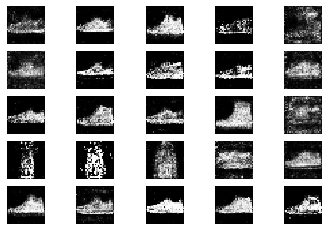

8601 [D loss: 0.341256, acc.: 87.50%] [G loss: 2.045658]
8602 [D loss: 0.499011, acc.: 78.12%] [G loss: 2.103902]
8603 [D loss: 0.398270, acc.: 87.50%] [G loss: 2.149534]
8604 [D loss: 0.440305, acc.: 76.56%] [G loss: 1.940739]
8605 [D loss: 0.313540, acc.: 84.38%] [G loss: 2.193197]
8606 [D loss: 0.309703, acc.: 89.06%] [G loss: 1.962233]
8607 [D loss: 0.474014, acc.: 78.12%] [G loss: 2.263516]
8608 [D loss: 0.514108, acc.: 73.44%] [G loss: 1.796976]
8609 [D loss: 0.446069, acc.: 82.81%] [G loss: 1.706331]
8610 [D loss: 0.225149, acc.: 93.75%] [G loss: 2.054184]
8611 [D loss: 0.317705, acc.: 89.06%] [G loss: 2.098420]
8612 [D loss: 0.281844, acc.: 90.62%] [G loss: 2.592290]
8613 [D loss: 0.327202, acc.: 89.06%] [G loss: 2.260046]
8614 [D loss: 0.340775, acc.: 84.38%] [G loss: 2.158490]
8615 [D loss: 0.359716, acc.: 84.38%] [G loss: 2.068487]
8616 [D loss: 0.391204, acc.: 85.94%] [G loss: 1.868713]
8617 [D loss: 0.527063, acc.: 81.25%] [G loss: 1.991790]
8618 [D loss: 0.281216, acc.: 8

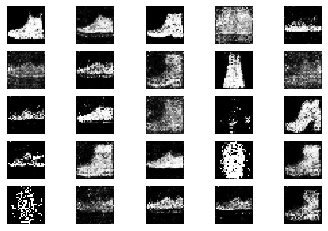

8801 [D loss: 0.335978, acc.: 85.94%] [G loss: 1.919247]
8802 [D loss: 0.369617, acc.: 85.94%] [G loss: 1.998385]
8803 [D loss: 0.341141, acc.: 84.38%] [G loss: 2.167369]
8804 [D loss: 0.471257, acc.: 78.12%] [G loss: 1.914065]
8805 [D loss: 0.288554, acc.: 87.50%] [G loss: 2.251273]
8806 [D loss: 0.370045, acc.: 82.81%] [G loss: 1.944122]
8807 [D loss: 0.327149, acc.: 79.69%] [G loss: 2.214955]
8808 [D loss: 0.255288, acc.: 89.06%] [G loss: 2.013074]
8809 [D loss: 0.235875, acc.: 90.62%] [G loss: 1.947212]
8810 [D loss: 0.241972, acc.: 90.62%] [G loss: 2.663319]
8811 [D loss: 0.362671, acc.: 85.94%] [G loss: 2.298257]
8812 [D loss: 0.329456, acc.: 87.50%] [G loss: 2.587961]
8813 [D loss: 0.396794, acc.: 82.81%] [G loss: 2.251647]
8814 [D loss: 0.289252, acc.: 87.50%] [G loss: 2.400986]
8815 [D loss: 0.502497, acc.: 82.81%] [G loss: 2.154342]
8816 [D loss: 0.458627, acc.: 79.69%] [G loss: 1.723240]
8817 [D loss: 0.500226, acc.: 79.69%] [G loss: 2.144671]
8818 [D loss: 0.450184, acc.: 7

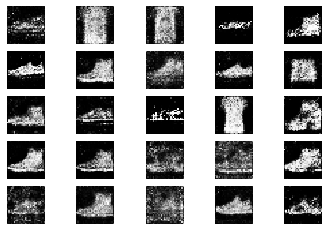

9001 [D loss: 0.340672, acc.: 82.81%] [G loss: 1.816505]
9002 [D loss: 0.336788, acc.: 85.94%] [G loss: 1.895883]
9003 [D loss: 0.397111, acc.: 84.38%] [G loss: 1.915444]
9004 [D loss: 0.453318, acc.: 82.81%] [G loss: 1.884527]
9005 [D loss: 0.311126, acc.: 84.38%] [G loss: 2.104585]
9006 [D loss: 0.399671, acc.: 85.94%] [G loss: 1.837335]
9007 [D loss: 0.339286, acc.: 85.94%] [G loss: 1.855915]
9008 [D loss: 0.172294, acc.: 93.75%] [G loss: 2.365305]
9009 [D loss: 0.568263, acc.: 71.88%] [G loss: 2.008722]
9010 [D loss: 0.325889, acc.: 85.94%] [G loss: 1.963624]
9011 [D loss: 0.481133, acc.: 81.25%] [G loss: 1.751951]
9012 [D loss: 0.323215, acc.: 85.94%] [G loss: 1.865220]
9013 [D loss: 0.287468, acc.: 90.62%] [G loss: 2.041213]
9014 [D loss: 0.157065, acc.: 96.88%] [G loss: 2.259495]
9015 [D loss: 0.396190, acc.: 84.38%] [G loss: 1.994752]
9016 [D loss: 0.281733, acc.: 89.06%] [G loss: 2.320020]
9017 [D loss: 0.394576, acc.: 87.50%] [G loss: 1.922629]
9018 [D loss: 0.423742, acc.: 8

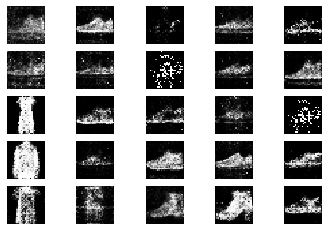

9201 [D loss: 0.510842, acc.: 73.44%] [G loss: 2.014689]
9202 [D loss: 0.259478, acc.: 90.62%] [G loss: 2.338471]
9203 [D loss: 0.327526, acc.: 85.94%] [G loss: 1.865940]
9204 [D loss: 0.251051, acc.: 90.62%] [G loss: 1.954118]
9205 [D loss: 0.336565, acc.: 85.94%] [G loss: 2.431775]
9206 [D loss: 0.454363, acc.: 79.69%] [G loss: 2.106837]
9207 [D loss: 0.425889, acc.: 81.25%] [G loss: 2.363209]
9208 [D loss: 0.239150, acc.: 92.19%] [G loss: 1.944310]
9209 [D loss: 0.238803, acc.: 92.19%] [G loss: 2.278038]
9210 [D loss: 0.279270, acc.: 93.75%] [G loss: 2.533106]
9211 [D loss: 0.307913, acc.: 85.94%] [G loss: 2.665910]
9212 [D loss: 0.505161, acc.: 79.69%] [G loss: 2.223237]
9213 [D loss: 0.386273, acc.: 82.81%] [G loss: 2.038453]
9214 [D loss: 0.246810, acc.: 90.62%] [G loss: 2.078328]
9215 [D loss: 0.337628, acc.: 87.50%] [G loss: 2.166149]
9216 [D loss: 0.413924, acc.: 79.69%] [G loss: 1.846744]
9217 [D loss: 0.291493, acc.: 90.62%] [G loss: 2.100891]
9218 [D loss: 0.395187, acc.: 8

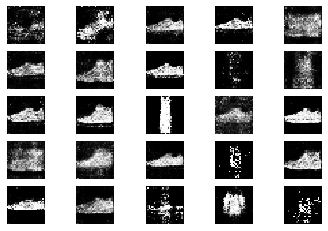

9401 [D loss: 0.387365, acc.: 81.25%] [G loss: 1.775223]
9402 [D loss: 0.323044, acc.: 82.81%] [G loss: 2.007558]
9403 [D loss: 0.232761, acc.: 90.62%] [G loss: 2.239148]
9404 [D loss: 0.393856, acc.: 85.94%] [G loss: 2.322067]
9405 [D loss: 0.255635, acc.: 90.62%] [G loss: 2.388180]
9406 [D loss: 0.339935, acc.: 84.38%] [G loss: 1.971057]
9407 [D loss: 0.392895, acc.: 84.38%] [G loss: 2.073183]
9408 [D loss: 0.431054, acc.: 85.94%] [G loss: 2.072528]
9409 [D loss: 0.412099, acc.: 78.12%] [G loss: 2.071263]
9410 [D loss: 0.305321, acc.: 89.06%] [G loss: 1.926544]
9411 [D loss: 0.306624, acc.: 89.06%] [G loss: 2.607172]
9412 [D loss: 0.308220, acc.: 87.50%] [G loss: 2.687946]
9413 [D loss: 0.317910, acc.: 84.38%] [G loss: 2.247137]
9414 [D loss: 0.353428, acc.: 85.94%] [G loss: 2.342940]
9415 [D loss: 0.224542, acc.: 90.62%] [G loss: 2.224699]
9416 [D loss: 0.307395, acc.: 82.81%] [G loss: 2.379848]
9417 [D loss: 0.377748, acc.: 81.25%] [G loss: 2.290711]
9418 [D loss: 0.383707, acc.: 8

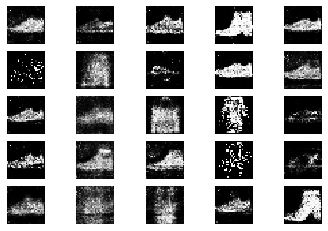

9601 [D loss: 0.264410, acc.: 90.62%] [G loss: 2.075780]
9602 [D loss: 0.339402, acc.: 84.38%] [G loss: 2.469161]
9603 [D loss: 0.314542, acc.: 85.94%] [G loss: 2.532712]
9604 [D loss: 0.315967, acc.: 89.06%] [G loss: 2.277329]
9605 [D loss: 0.268032, acc.: 90.62%] [G loss: 2.450365]
9606 [D loss: 0.308945, acc.: 82.81%] [G loss: 2.192760]
9607 [D loss: 0.360059, acc.: 84.38%] [G loss: 1.982626]
9608 [D loss: 0.430438, acc.: 79.69%] [G loss: 2.211262]
9609 [D loss: 0.404266, acc.: 82.81%] [G loss: 1.877822]
9610 [D loss: 0.374925, acc.: 82.81%] [G loss: 1.810932]
9611 [D loss: 0.312987, acc.: 85.94%] [G loss: 2.140179]
9612 [D loss: 0.415245, acc.: 82.81%] [G loss: 1.828562]
9613 [D loss: 0.217001, acc.: 90.62%] [G loss: 2.037220]
9614 [D loss: 0.494600, acc.: 75.00%] [G loss: 1.921203]
9615 [D loss: 0.174995, acc.: 95.31%] [G loss: 2.005751]
9616 [D loss: 0.364484, acc.: 82.81%] [G loss: 1.947117]
9617 [D loss: 0.196028, acc.: 92.19%] [G loss: 2.370055]
9618 [D loss: 0.362051, acc.: 8

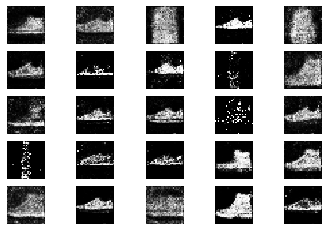

9801 [D loss: 0.242712, acc.: 89.06%] [G loss: 1.935207]
9802 [D loss: 0.559688, acc.: 71.88%] [G loss: 2.107761]
9803 [D loss: 0.497882, acc.: 78.12%] [G loss: 2.061752]
9804 [D loss: 0.398927, acc.: 81.25%] [G loss: 2.043811]
9805 [D loss: 0.354404, acc.: 82.81%] [G loss: 2.042050]
9806 [D loss: 0.357063, acc.: 82.81%] [G loss: 2.190630]
9807 [D loss: 0.301311, acc.: 85.94%] [G loss: 1.950646]
9808 [D loss: 0.271044, acc.: 87.50%] [G loss: 1.886336]
9809 [D loss: 0.419384, acc.: 84.38%] [G loss: 1.942733]
9810 [D loss: 0.260570, acc.: 90.62%] [G loss: 2.106400]
9811 [D loss: 0.408239, acc.: 78.12%] [G loss: 2.005855]
9812 [D loss: 0.384673, acc.: 84.38%] [G loss: 2.032504]
9813 [D loss: 0.342006, acc.: 82.81%] [G loss: 2.175436]
9814 [D loss: 0.382530, acc.: 82.81%] [G loss: 2.149076]
9815 [D loss: 0.327986, acc.: 85.94%] [G loss: 1.984979]
9816 [D loss: 0.457801, acc.: 78.12%] [G loss: 2.078321]
9817 [D loss: 0.366236, acc.: 84.38%] [G loss: 2.354745]
9818 [D loss: 0.403570, acc.: 8

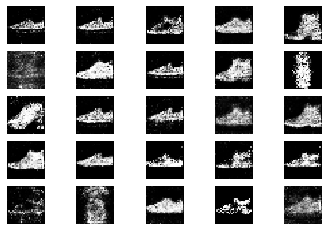

10001 [D loss: 0.411115, acc.: 79.69%] [G loss: 1.690879]
10002 [D loss: 0.214027, acc.: 92.19%] [G loss: 1.851624]
10003 [D loss: 0.344226, acc.: 85.94%] [G loss: 1.892076]
10004 [D loss: 0.408935, acc.: 82.81%] [G loss: 1.973952]
10005 [D loss: 0.446816, acc.: 75.00%] [G loss: 1.852928]
10006 [D loss: 0.331892, acc.: 84.38%] [G loss: 1.723349]
10007 [D loss: 0.306190, acc.: 85.94%] [G loss: 2.030448]
10008 [D loss: 0.273731, acc.: 87.50%] [G loss: 2.111156]
10009 [D loss: 0.372151, acc.: 82.81%] [G loss: 1.916084]
10010 [D loss: 0.357944, acc.: 85.94%] [G loss: 1.885910]
10011 [D loss: 0.351621, acc.: 84.38%] [G loss: 1.713247]
10012 [D loss: 0.467885, acc.: 71.88%] [G loss: 1.733842]
10013 [D loss: 0.238751, acc.: 87.50%] [G loss: 2.185531]
10014 [D loss: 0.275899, acc.: 90.62%] [G loss: 2.218804]
10015 [D loss: 0.401224, acc.: 79.69%] [G loss: 2.208051]
10016 [D loss: 0.228420, acc.: 93.75%] [G loss: 1.971737]
10017 [D loss: 0.513005, acc.: 78.12%] [G loss: 1.961360]
10018 [D loss:

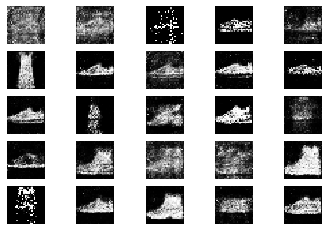

10201 [D loss: 0.254981, acc.: 89.06%] [G loss: 2.469511]
10202 [D loss: 0.381854, acc.: 81.25%] [G loss: 1.781237]
10203 [D loss: 0.366196, acc.: 87.50%] [G loss: 2.300471]
10204 [D loss: 0.361994, acc.: 85.94%] [G loss: 2.045013]
10205 [D loss: 0.369827, acc.: 84.38%] [G loss: 1.961289]
10206 [D loss: 0.485535, acc.: 79.69%] [G loss: 2.099026]
10207 [D loss: 0.337863, acc.: 82.81%] [G loss: 1.462160]
10208 [D loss: 0.407255, acc.: 81.25%] [G loss: 1.873463]
10209 [D loss: 0.294380, acc.: 89.06%] [G loss: 2.164325]
10210 [D loss: 0.194332, acc.: 92.19%] [G loss: 2.445396]
10211 [D loss: 0.219314, acc.: 90.62%] [G loss: 2.553713]
10212 [D loss: 0.299158, acc.: 89.06%] [G loss: 2.044420]
10213 [D loss: 0.272819, acc.: 89.06%] [G loss: 2.268926]
10214 [D loss: 0.484849, acc.: 73.44%] [G loss: 1.720576]
10215 [D loss: 0.302842, acc.: 89.06%] [G loss: 1.744200]
10216 [D loss: 0.241122, acc.: 90.62%] [G loss: 2.049263]
10217 [D loss: 0.320065, acc.: 87.50%] [G loss: 1.933165]
10218 [D loss:

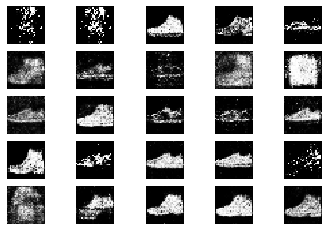

10401 [D loss: 0.359053, acc.: 84.38%] [G loss: 2.003264]
10402 [D loss: 0.485953, acc.: 79.69%] [G loss: 1.716938]
10403 [D loss: 0.287125, acc.: 85.94%] [G loss: 2.033832]
10404 [D loss: 0.410795, acc.: 76.56%] [G loss: 1.829931]
10405 [D loss: 0.416701, acc.: 76.56%] [G loss: 1.599559]
10406 [D loss: 0.263685, acc.: 89.06%] [G loss: 2.089573]
10407 [D loss: 0.328737, acc.: 87.50%] [G loss: 2.244704]
10408 [D loss: 0.436180, acc.: 78.12%] [G loss: 1.886939]
10409 [D loss: 0.441607, acc.: 79.69%] [G loss: 1.927019]
10410 [D loss: 0.264583, acc.: 90.62%] [G loss: 2.037777]
10411 [D loss: 0.379966, acc.: 81.25%] [G loss: 1.772945]
10412 [D loss: 0.301931, acc.: 87.50%] [G loss: 2.014724]
10413 [D loss: 0.324846, acc.: 87.50%] [G loss: 2.127625]
10414 [D loss: 0.412785, acc.: 81.25%] [G loss: 2.013262]
10415 [D loss: 0.284566, acc.: 87.50%] [G loss: 2.071067]
10416 [D loss: 0.335379, acc.: 82.81%] [G loss: 2.091396]
10417 [D loss: 0.349157, acc.: 89.06%] [G loss: 1.965385]
10418 [D loss:

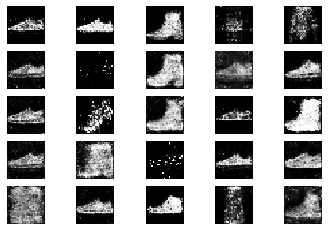

10601 [D loss: 0.311216, acc.: 89.06%] [G loss: 2.255599]
10602 [D loss: 0.529515, acc.: 78.12%] [G loss: 2.023443]
10603 [D loss: 0.337358, acc.: 85.94%] [G loss: 2.069252]
10604 [D loss: 0.383227, acc.: 85.94%] [G loss: 2.020857]
10605 [D loss: 0.209270, acc.: 96.88%] [G loss: 2.013737]
10606 [D loss: 0.286576, acc.: 87.50%] [G loss: 2.037487]
10607 [D loss: 0.323552, acc.: 85.94%] [G loss: 1.962360]
10608 [D loss: 0.385388, acc.: 81.25%] [G loss: 1.960386]
10609 [D loss: 0.555690, acc.: 73.44%] [G loss: 1.790066]
10610 [D loss: 0.316927, acc.: 84.38%] [G loss: 1.936478]
10611 [D loss: 0.233488, acc.: 90.62%] [G loss: 1.750799]
10612 [D loss: 0.330369, acc.: 89.06%] [G loss: 1.928688]
10613 [D loss: 0.525519, acc.: 78.12%] [G loss: 1.647587]
10614 [D loss: 0.275460, acc.: 90.62%] [G loss: 1.786176]
10615 [D loss: 0.302457, acc.: 90.62%] [G loss: 1.955597]
10616 [D loss: 0.312136, acc.: 87.50%] [G loss: 1.592808]
10617 [D loss: 0.260067, acc.: 85.94%] [G loss: 1.850967]
10618 [D loss:

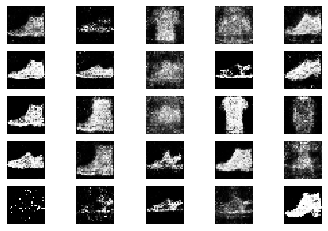

10801 [D loss: 0.418663, acc.: 82.81%] [G loss: 2.039331]
10802 [D loss: 0.211774, acc.: 95.31%] [G loss: 1.832652]
10803 [D loss: 0.412338, acc.: 79.69%] [G loss: 2.179400]
10804 [D loss: 0.426329, acc.: 85.94%] [G loss: 1.843276]
10805 [D loss: 0.414178, acc.: 84.38%] [G loss: 1.735808]
10806 [D loss: 0.373587, acc.: 81.25%] [G loss: 1.770604]
10807 [D loss: 0.399989, acc.: 79.69%] [G loss: 1.667525]
10808 [D loss: 0.409071, acc.: 82.81%] [G loss: 1.601600]
10809 [D loss: 0.295105, acc.: 89.06%] [G loss: 1.987864]
10810 [D loss: 0.377952, acc.: 81.25%] [G loss: 1.813672]
10811 [D loss: 0.399613, acc.: 76.56%] [G loss: 1.599565]
10812 [D loss: 0.307991, acc.: 87.50%] [G loss: 1.963583]
10813 [D loss: 0.408950, acc.: 79.69%] [G loss: 2.124800]
10814 [D loss: 0.295984, acc.: 90.62%] [G loss: 2.329032]
10815 [D loss: 0.288170, acc.: 85.94%] [G loss: 2.290393]
10816 [D loss: 0.346616, acc.: 84.38%] [G loss: 2.355799]
10817 [D loss: 0.470086, acc.: 81.25%] [G loss: 2.447920]
10818 [D loss:

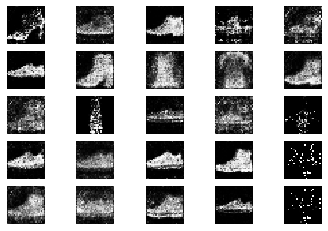

11001 [D loss: 0.336611, acc.: 84.38%] [G loss: 2.275144]
11002 [D loss: 0.263321, acc.: 89.06%] [G loss: 2.240200]
11003 [D loss: 0.313600, acc.: 84.38%] [G loss: 1.951858]
11004 [D loss: 0.451898, acc.: 81.25%] [G loss: 2.495643]
11005 [D loss: 0.289082, acc.: 92.19%] [G loss: 2.426713]
11006 [D loss: 0.351912, acc.: 82.81%] [G loss: 2.612967]
11007 [D loss: 0.346226, acc.: 82.81%] [G loss: 1.992218]
11008 [D loss: 0.334276, acc.: 84.38%] [G loss: 2.177309]
11009 [D loss: 0.226141, acc.: 93.75%] [G loss: 1.845913]
11010 [D loss: 0.236818, acc.: 92.19%] [G loss: 1.945159]
11011 [D loss: 0.239063, acc.: 90.62%] [G loss: 2.208957]
11012 [D loss: 0.416126, acc.: 81.25%] [G loss: 2.329643]
11013 [D loss: 0.338481, acc.: 84.38%] [G loss: 2.029314]
11014 [D loss: 0.358570, acc.: 85.94%] [G loss: 1.884443]
11015 [D loss: 0.335082, acc.: 84.38%] [G loss: 2.043848]
11016 [D loss: 0.265588, acc.: 92.19%] [G loss: 1.948300]
11017 [D loss: 0.287689, acc.: 87.50%] [G loss: 2.317673]
11018 [D loss:

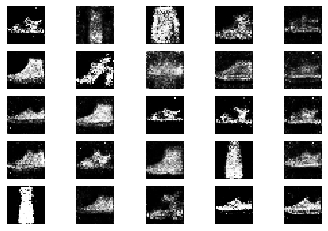

11201 [D loss: 0.384386, acc.: 82.81%] [G loss: 2.396844]
11202 [D loss: 0.302370, acc.: 85.94%] [G loss: 2.318996]
11203 [D loss: 0.294632, acc.: 87.50%] [G loss: 2.144084]
11204 [D loss: 0.292663, acc.: 87.50%] [G loss: 2.171838]
11205 [D loss: 0.269857, acc.: 85.94%] [G loss: 2.411158]
11206 [D loss: 0.529532, acc.: 79.69%] [G loss: 1.981069]
11207 [D loss: 0.306577, acc.: 87.50%] [G loss: 1.793303]
11208 [D loss: 0.326400, acc.: 87.50%] [G loss: 2.186207]
11209 [D loss: 0.371458, acc.: 82.81%] [G loss: 1.827362]
11210 [D loss: 0.416746, acc.: 85.94%] [G loss: 2.109477]
11211 [D loss: 0.260484, acc.: 90.62%] [G loss: 2.092448]
11212 [D loss: 0.358837, acc.: 85.94%] [G loss: 2.130306]
11213 [D loss: 0.213467, acc.: 90.62%] [G loss: 2.193660]
11214 [D loss: 0.301885, acc.: 90.62%] [G loss: 2.301024]
11215 [D loss: 0.329514, acc.: 89.06%] [G loss: 2.003997]
11216 [D loss: 0.344239, acc.: 82.81%] [G loss: 2.020226]
11217 [D loss: 0.329252, acc.: 87.50%] [G loss: 1.776800]
11218 [D loss:

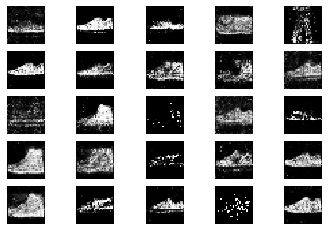

11401 [D loss: 0.459381, acc.: 81.25%] [G loss: 1.985399]
11402 [D loss: 0.432795, acc.: 79.69%] [G loss: 2.069300]
11403 [D loss: 0.239207, acc.: 93.75%] [G loss: 1.959777]
11404 [D loss: 0.382797, acc.: 84.38%] [G loss: 1.864371]
11405 [D loss: 0.415283, acc.: 78.12%] [G loss: 2.122118]
11406 [D loss: 0.419721, acc.: 84.38%] [G loss: 1.967061]
11407 [D loss: 0.339632, acc.: 87.50%] [G loss: 1.828545]
11408 [D loss: 0.326229, acc.: 89.06%] [G loss: 1.908143]
11409 [D loss: 0.213325, acc.: 92.19%] [G loss: 2.019153]
11410 [D loss: 0.629972, acc.: 76.56%] [G loss: 1.573470]
11411 [D loss: 0.241025, acc.: 92.19%] [G loss: 1.768269]
11412 [D loss: 0.372394, acc.: 82.81%] [G loss: 2.118506]
11413 [D loss: 0.371828, acc.: 81.25%] [G loss: 2.039014]
11414 [D loss: 0.350662, acc.: 85.94%] [G loss: 2.005522]
11415 [D loss: 0.457644, acc.: 84.38%] [G loss: 1.879246]
11416 [D loss: 0.360890, acc.: 84.38%] [G loss: 1.961524]
11417 [D loss: 0.205380, acc.: 90.62%] [G loss: 2.197543]
11418 [D loss:

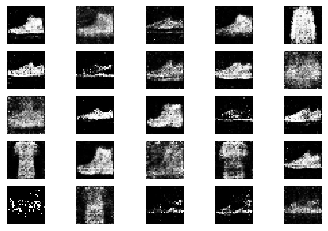

11601 [D loss: 0.276038, acc.: 89.06%] [G loss: 2.117471]
11602 [D loss: 0.353918, acc.: 81.25%] [G loss: 2.333415]
11603 [D loss: 0.308903, acc.: 85.94%] [G loss: 2.244882]
11604 [D loss: 0.444559, acc.: 81.25%] [G loss: 1.724158]
11605 [D loss: 0.263317, acc.: 89.06%] [G loss: 2.081064]
11606 [D loss: 0.404561, acc.: 81.25%] [G loss: 1.608719]
11607 [D loss: 0.261298, acc.: 93.75%] [G loss: 1.825872]
11608 [D loss: 0.393389, acc.: 84.38%] [G loss: 2.466995]
11609 [D loss: 0.317793, acc.: 87.50%] [G loss: 2.299285]
11610 [D loss: 0.460291, acc.: 78.12%] [G loss: 2.162758]
11611 [D loss: 0.431117, acc.: 79.69%] [G loss: 2.404313]
11612 [D loss: 0.380845, acc.: 79.69%] [G loss: 1.772241]
11613 [D loss: 0.238355, acc.: 92.19%] [G loss: 2.931170]
11614 [D loss: 0.316590, acc.: 84.38%] [G loss: 2.627825]
11615 [D loss: 0.572984, acc.: 71.88%] [G loss: 2.044127]
11616 [D loss: 0.288210, acc.: 87.50%] [G loss: 2.410331]
11617 [D loss: 0.417375, acc.: 81.25%] [G loss: 2.527656]
11618 [D loss:

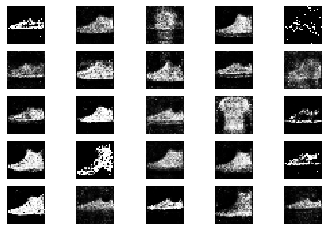

11801 [D loss: 0.340783, acc.: 84.38%] [G loss: 2.020549]
11802 [D loss: 0.289975, acc.: 87.50%] [G loss: 2.137156]
11803 [D loss: 0.254964, acc.: 89.06%] [G loss: 2.304977]
11804 [D loss: 0.358373, acc.: 85.94%] [G loss: 2.002946]
11805 [D loss: 0.262657, acc.: 85.94%] [G loss: 1.940842]
11806 [D loss: 0.450252, acc.: 82.81%] [G loss: 2.080192]
11807 [D loss: 0.418907, acc.: 79.69%] [G loss: 2.106183]
11808 [D loss: 0.417567, acc.: 84.38%] [G loss: 1.846757]
11809 [D loss: 0.441170, acc.: 79.69%] [G loss: 2.013860]
11810 [D loss: 0.278100, acc.: 87.50%] [G loss: 1.953296]
11811 [D loss: 0.314561, acc.: 85.94%] [G loss: 1.955794]
11812 [D loss: 0.374234, acc.: 81.25%] [G loss: 2.041084]
11813 [D loss: 0.442704, acc.: 78.12%] [G loss: 1.866990]
11814 [D loss: 0.242276, acc.: 90.62%] [G loss: 1.928814]
11815 [D loss: 0.312959, acc.: 84.38%] [G loss: 1.953792]
11816 [D loss: 0.348510, acc.: 84.38%] [G loss: 2.187010]
11817 [D loss: 0.331634, acc.: 85.94%] [G loss: 2.118814]
11818 [D loss:

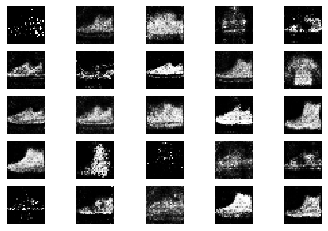

12001 [D loss: 0.285164, acc.: 87.50%] [G loss: 1.978787]
12002 [D loss: 0.351717, acc.: 84.38%] [G loss: 2.281869]
12003 [D loss: 0.357744, acc.: 84.38%] [G loss: 2.203241]
12004 [D loss: 0.432382, acc.: 85.94%] [G loss: 2.290392]
12005 [D loss: 0.336124, acc.: 81.25%] [G loss: 2.258535]
12006 [D loss: 0.264571, acc.: 87.50%] [G loss: 1.959016]
12007 [D loss: 0.275586, acc.: 89.06%] [G loss: 2.235956]
12008 [D loss: 0.204464, acc.: 90.62%] [G loss: 2.152556]
12009 [D loss: 0.332687, acc.: 87.50%] [G loss: 2.001418]
12010 [D loss: 0.398921, acc.: 79.69%] [G loss: 2.126253]
12011 [D loss: 0.225141, acc.: 92.19%] [G loss: 2.171352]
12012 [D loss: 0.255349, acc.: 90.62%] [G loss: 2.400746]
12013 [D loss: 0.292731, acc.: 87.50%] [G loss: 2.565365]
12014 [D loss: 0.321934, acc.: 89.06%] [G loss: 1.643459]
12015 [D loss: 0.335982, acc.: 87.50%] [G loss: 2.086451]
12016 [D loss: 0.237978, acc.: 89.06%] [G loss: 2.375839]
12017 [D loss: 0.331965, acc.: 90.62%] [G loss: 2.091842]
12018 [D loss:

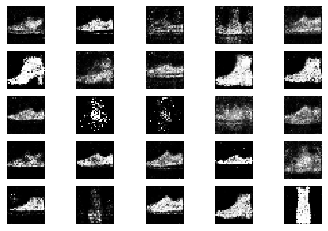

12201 [D loss: 0.346965, acc.: 82.81%] [G loss: 1.718084]
12202 [D loss: 0.480473, acc.: 81.25%] [G loss: 1.811232]
12203 [D loss: 0.376481, acc.: 81.25%] [G loss: 2.039713]
12204 [D loss: 0.363062, acc.: 84.38%] [G loss: 1.931071]
12205 [D loss: 0.408386, acc.: 81.25%] [G loss: 1.964465]
12206 [D loss: 0.278308, acc.: 92.19%] [G loss: 2.128242]
12207 [D loss: 0.357932, acc.: 85.94%] [G loss: 2.733049]
12208 [D loss: 0.348495, acc.: 84.38%] [G loss: 2.301065]
12209 [D loss: 0.344824, acc.: 87.50%] [G loss: 2.342278]
12210 [D loss: 0.319692, acc.: 89.06%] [G loss: 2.331678]
12211 [D loss: 0.395537, acc.: 78.12%] [G loss: 1.997953]
12212 [D loss: 0.354343, acc.: 85.94%] [G loss: 2.036275]
12213 [D loss: 0.275711, acc.: 90.62%] [G loss: 2.131729]
12214 [D loss: 0.290520, acc.: 89.06%] [G loss: 2.460736]
12215 [D loss: 0.212022, acc.: 89.06%] [G loss: 2.447098]
12216 [D loss: 0.406279, acc.: 84.38%] [G loss: 2.240800]
12217 [D loss: 0.289521, acc.: 90.62%] [G loss: 2.091964]
12218 [D loss:

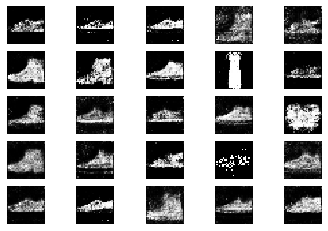

12401 [D loss: 0.252500, acc.: 87.50%] [G loss: 2.087718]
12402 [D loss: 0.524711, acc.: 76.56%] [G loss: 2.224654]
12403 [D loss: 0.318548, acc.: 85.94%] [G loss: 1.927982]
12404 [D loss: 0.340851, acc.: 85.94%] [G loss: 2.065424]
12405 [D loss: 0.232823, acc.: 93.75%] [G loss: 2.181534]
12406 [D loss: 0.433472, acc.: 79.69%] [G loss: 2.047125]
12407 [D loss: 0.295302, acc.: 85.94%] [G loss: 2.249279]
12408 [D loss: 0.331731, acc.: 85.94%] [G loss: 2.281448]
12409 [D loss: 0.291258, acc.: 84.38%] [G loss: 2.301399]
12410 [D loss: 0.477191, acc.: 79.69%] [G loss: 1.892962]
12411 [D loss: 0.350584, acc.: 84.38%] [G loss: 2.606768]
12412 [D loss: 0.453084, acc.: 78.12%] [G loss: 2.015154]
12413 [D loss: 0.370455, acc.: 81.25%] [G loss: 1.997406]
12414 [D loss: 0.359334, acc.: 84.38%] [G loss: 2.045403]
12415 [D loss: 0.386689, acc.: 84.38%] [G loss: 2.109416]
12416 [D loss: 0.392179, acc.: 84.38%] [G loss: 1.828965]
12417 [D loss: 0.484802, acc.: 73.44%] [G loss: 2.253812]
12418 [D loss:

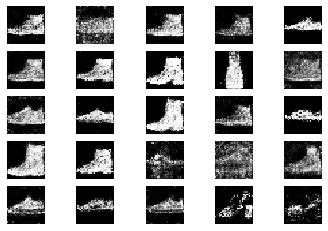

12601 [D loss: 0.291036, acc.: 87.50%] [G loss: 1.985327]
12602 [D loss: 0.455022, acc.: 78.12%] [G loss: 1.861960]
12603 [D loss: 0.387586, acc.: 82.81%] [G loss: 1.833531]
12604 [D loss: 0.250866, acc.: 92.19%] [G loss: 2.101900]
12605 [D loss: 0.399030, acc.: 79.69%] [G loss: 1.899313]
12606 [D loss: 0.326842, acc.: 85.94%] [G loss: 1.831521]
12607 [D loss: 0.302549, acc.: 87.50%] [G loss: 1.737075]
12608 [D loss: 0.388928, acc.: 82.81%] [G loss: 2.098400]
12609 [D loss: 0.207726, acc.: 92.19%] [G loss: 2.111412]
12610 [D loss: 0.228630, acc.: 90.62%] [G loss: 2.345372]
12611 [D loss: 0.292621, acc.: 89.06%] [G loss: 2.646916]
12612 [D loss: 0.411298, acc.: 87.50%] [G loss: 2.036958]
12613 [D loss: 0.265849, acc.: 90.62%] [G loss: 2.172393]
12614 [D loss: 0.332525, acc.: 85.94%] [G loss: 2.405972]
12615 [D loss: 0.339429, acc.: 89.06%] [G loss: 2.366119]
12616 [D loss: 0.428986, acc.: 84.38%] [G loss: 2.290712]
12617 [D loss: 0.324485, acc.: 89.06%] [G loss: 2.034106]
12618 [D loss:

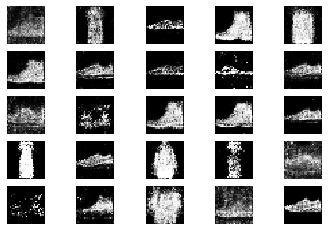

12801 [D loss: 0.340044, acc.: 82.81%] [G loss: 1.937656]
12802 [D loss: 0.250776, acc.: 93.75%] [G loss: 2.203018]
12803 [D loss: 0.397157, acc.: 81.25%] [G loss: 2.002337]
12804 [D loss: 0.516836, acc.: 75.00%] [G loss: 2.006334]
12805 [D loss: 0.335157, acc.: 84.38%] [G loss: 2.091719]
12806 [D loss: 0.339026, acc.: 85.94%] [G loss: 2.003256]
12807 [D loss: 0.309089, acc.: 87.50%] [G loss: 1.759899]
12808 [D loss: 0.290202, acc.: 89.06%] [G loss: 2.082645]
12809 [D loss: 0.246643, acc.: 89.06%] [G loss: 2.003216]
12810 [D loss: 0.338167, acc.: 85.94%] [G loss: 2.076287]
12811 [D loss: 0.356135, acc.: 82.81%] [G loss: 1.840014]
12812 [D loss: 0.317212, acc.: 85.94%] [G loss: 1.893444]
12813 [D loss: 0.321363, acc.: 87.50%] [G loss: 2.278828]
12814 [D loss: 0.450207, acc.: 79.69%] [G loss: 1.791442]
12815 [D loss: 0.267306, acc.: 90.62%] [G loss: 2.222137]
12816 [D loss: 0.322427, acc.: 87.50%] [G loss: 2.199470]
12817 [D loss: 0.428954, acc.: 84.38%] [G loss: 2.145592]
12818 [D loss:

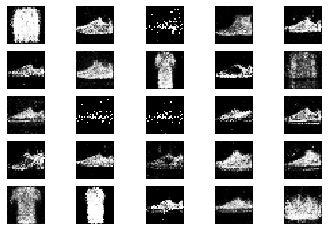

13001 [D loss: 0.460797, acc.: 82.81%] [G loss: 1.999191]
13002 [D loss: 0.340366, acc.: 84.38%] [G loss: 2.088584]
13003 [D loss: 0.489623, acc.: 78.12%] [G loss: 1.975870]
13004 [D loss: 0.345601, acc.: 82.81%] [G loss: 1.789432]
13005 [D loss: 0.385058, acc.: 81.25%] [G loss: 2.027689]
13006 [D loss: 0.344407, acc.: 85.94%] [G loss: 2.026637]
13007 [D loss: 0.359669, acc.: 84.38%] [G loss: 1.919636]
13008 [D loss: 0.499978, acc.: 75.00%] [G loss: 2.060786]
13009 [D loss: 0.324939, acc.: 81.25%] [G loss: 2.269516]
13010 [D loss: 0.337487, acc.: 89.06%] [G loss: 1.965573]
13011 [D loss: 0.272560, acc.: 89.06%] [G loss: 1.710085]
13012 [D loss: 0.328775, acc.: 87.50%] [G loss: 2.085284]
13013 [D loss: 0.340440, acc.: 79.69%] [G loss: 1.975960]
13014 [D loss: 0.304551, acc.: 84.38%] [G loss: 2.175355]
13015 [D loss: 0.365855, acc.: 82.81%] [G loss: 2.189613]
13016 [D loss: 0.363829, acc.: 84.38%] [G loss: 1.787077]
13017 [D loss: 0.336246, acc.: 89.06%] [G loss: 1.686276]
13018 [D loss:

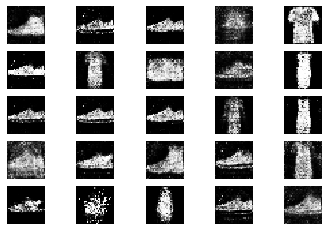

13201 [D loss: 0.448156, acc.: 81.25%] [G loss: 1.750482]
13202 [D loss: 0.253899, acc.: 90.62%] [G loss: 2.086015]
13203 [D loss: 0.323544, acc.: 89.06%] [G loss: 2.152527]
13204 [D loss: 0.309586, acc.: 85.94%] [G loss: 2.166699]
13205 [D loss: 0.353305, acc.: 85.94%] [G loss: 1.858159]
13206 [D loss: 0.288325, acc.: 89.06%] [G loss: 1.986113]
13207 [D loss: 0.358837, acc.: 81.25%] [G loss: 1.661448]
13208 [D loss: 0.359975, acc.: 87.50%] [G loss: 1.838158]
13209 [D loss: 0.301039, acc.: 90.62%] [G loss: 1.612260]
13210 [D loss: 0.301523, acc.: 85.94%] [G loss: 1.932661]
13211 [D loss: 0.544149, acc.: 78.12%] [G loss: 1.733354]
13212 [D loss: 0.320685, acc.: 85.94%] [G loss: 2.163666]
13213 [D loss: 0.317607, acc.: 82.81%] [G loss: 2.045737]
13214 [D loss: 0.301334, acc.: 89.06%] [G loss: 2.000662]
13215 [D loss: 0.328201, acc.: 87.50%] [G loss: 1.969305]
13216 [D loss: 0.317178, acc.: 84.38%] [G loss: 1.839616]
13217 [D loss: 0.459268, acc.: 81.25%] [G loss: 1.730830]
13218 [D loss:

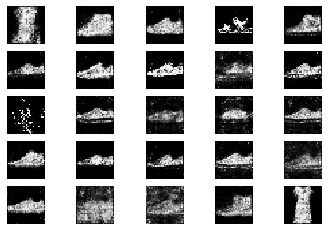

13401 [D loss: 0.327910, acc.: 87.50%] [G loss: 2.491488]
13402 [D loss: 0.203417, acc.: 96.88%] [G loss: 2.425217]
13403 [D loss: 0.383367, acc.: 84.38%] [G loss: 2.060789]
13404 [D loss: 0.318792, acc.: 85.94%] [G loss: 2.140900]
13405 [D loss: 0.457513, acc.: 81.25%] [G loss: 2.381358]
13406 [D loss: 0.374529, acc.: 82.81%] [G loss: 2.054543]
13407 [D loss: 0.349889, acc.: 85.94%] [G loss: 2.092514]
13408 [D loss: 0.299854, acc.: 89.06%] [G loss: 2.074117]
13409 [D loss: 0.259910, acc.: 89.06%] [G loss: 1.898719]
13410 [D loss: 0.265868, acc.: 87.50%] [G loss: 2.067692]
13411 [D loss: 0.195504, acc.: 93.75%] [G loss: 2.040906]
13412 [D loss: 0.453342, acc.: 76.56%] [G loss: 2.366587]
13413 [D loss: 0.301014, acc.: 87.50%] [G loss: 2.314480]
13414 [D loss: 0.243604, acc.: 90.62%] [G loss: 2.256985]
13415 [D loss: 0.346143, acc.: 85.94%] [G loss: 2.184461]
13416 [D loss: 0.412853, acc.: 81.25%] [G loss: 1.711621]
13417 [D loss: 0.399189, acc.: 81.25%] [G loss: 2.157770]
13418 [D loss:

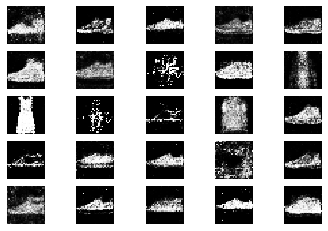

13601 [D loss: 0.375240, acc.: 81.25%] [G loss: 1.966757]
13602 [D loss: 0.414460, acc.: 81.25%] [G loss: 1.706890]
13603 [D loss: 0.217434, acc.: 90.62%] [G loss: 2.058770]
13604 [D loss: 0.383142, acc.: 81.25%] [G loss: 1.760836]
13605 [D loss: 0.324284, acc.: 85.94%] [G loss: 2.065893]
13606 [D loss: 0.415978, acc.: 84.38%] [G loss: 2.140158]
13607 [D loss: 0.251519, acc.: 89.06%] [G loss: 2.221255]
13608 [D loss: 0.335740, acc.: 89.06%] [G loss: 2.080739]
13609 [D loss: 0.254725, acc.: 90.62%] [G loss: 2.289411]
13610 [D loss: 0.379077, acc.: 84.38%] [G loss: 2.389871]
13611 [D loss: 0.428053, acc.: 82.81%] [G loss: 2.080306]
13612 [D loss: 0.294203, acc.: 89.06%] [G loss: 2.009523]
13613 [D loss: 0.376822, acc.: 84.38%] [G loss: 2.379323]
13614 [D loss: 0.300996, acc.: 90.62%] [G loss: 2.286158]
13615 [D loss: 0.270755, acc.: 85.94%] [G loss: 2.420673]
13616 [D loss: 0.252292, acc.: 90.62%] [G loss: 2.527078]
13617 [D loss: 0.236330, acc.: 92.19%] [G loss: 2.253025]
13618 [D loss:

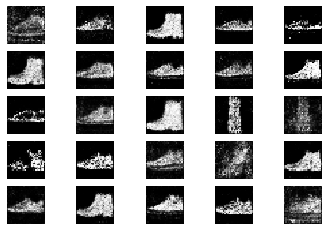

13801 [D loss: 0.302904, acc.: 84.38%] [G loss: 1.862380]
13802 [D loss: 0.331488, acc.: 84.38%] [G loss: 2.026995]
13803 [D loss: 0.265966, acc.: 90.62%] [G loss: 2.281938]
13804 [D loss: 0.315907, acc.: 85.94%] [G loss: 2.106882]
13805 [D loss: 0.418405, acc.: 81.25%] [G loss: 2.025918]
13806 [D loss: 0.256193, acc.: 87.50%] [G loss: 1.923793]
13807 [D loss: 0.396800, acc.: 82.81%] [G loss: 1.763716]
13808 [D loss: 0.576064, acc.: 67.19%] [G loss: 1.978494]
13809 [D loss: 0.334018, acc.: 85.94%] [G loss: 1.871644]
13810 [D loss: 0.233986, acc.: 92.19%] [G loss: 2.023062]
13811 [D loss: 0.352634, acc.: 81.25%] [G loss: 2.041895]
13812 [D loss: 0.421658, acc.: 79.69%] [G loss: 2.163737]
13813 [D loss: 0.326865, acc.: 85.94%] [G loss: 2.113584]
13814 [D loss: 0.317309, acc.: 87.50%] [G loss: 1.875542]
13815 [D loss: 0.327997, acc.: 84.38%] [G loss: 2.220454]
13816 [D loss: 0.338237, acc.: 79.69%] [G loss: 2.003376]
13817 [D loss: 0.228579, acc.: 90.62%] [G loss: 2.362946]
13818 [D loss:

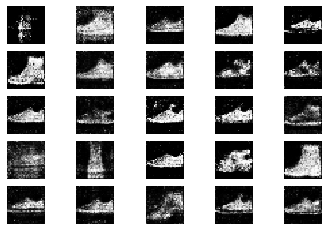

14001 [D loss: 0.251556, acc.: 90.62%] [G loss: 2.307027]
14002 [D loss: 0.285927, acc.: 90.62%] [G loss: 2.147181]
14003 [D loss: 0.330223, acc.: 85.94%] [G loss: 2.010685]
14004 [D loss: 0.355828, acc.: 82.81%] [G loss: 2.113497]
14005 [D loss: 0.272981, acc.: 89.06%] [G loss: 2.375676]
14006 [D loss: 0.384945, acc.: 82.81%] [G loss: 2.183625]
14007 [D loss: 0.442218, acc.: 82.81%] [G loss: 1.843287]
14008 [D loss: 0.367208, acc.: 84.38%] [G loss: 1.953510]
14009 [D loss: 0.385513, acc.: 82.81%] [G loss: 1.747944]
14010 [D loss: 0.289935, acc.: 89.06%] [G loss: 1.902390]
14011 [D loss: 0.448621, acc.: 78.12%] [G loss: 1.701748]
14012 [D loss: 0.254085, acc.: 87.50%] [G loss: 2.105399]
14013 [D loss: 0.337259, acc.: 89.06%] [G loss: 2.573795]
14014 [D loss: 0.368310, acc.: 84.38%] [G loss: 2.509427]
14015 [D loss: 0.297558, acc.: 87.50%] [G loss: 2.131901]
14016 [D loss: 0.409616, acc.: 81.25%] [G loss: 1.852605]
14017 [D loss: 0.342031, acc.: 87.50%] [G loss: 1.795136]
14018 [D loss:

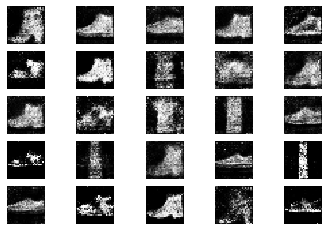

14201 [D loss: 0.140665, acc.: 96.88%] [G loss: 2.329964]
14202 [D loss: 0.326301, acc.: 85.94%] [G loss: 2.226030]
14203 [D loss: 0.360540, acc.: 85.94%] [G loss: 2.110490]
14204 [D loss: 0.360045, acc.: 84.38%] [G loss: 1.994365]
14205 [D loss: 0.279589, acc.: 87.50%] [G loss: 2.015188]
14206 [D loss: 0.494037, acc.: 76.56%] [G loss: 2.166571]
14207 [D loss: 0.441310, acc.: 82.81%] [G loss: 1.831830]
14208 [D loss: 0.430926, acc.: 81.25%] [G loss: 1.789180]
14209 [D loss: 0.260123, acc.: 90.62%] [G loss: 2.034879]
14210 [D loss: 0.304710, acc.: 89.06%] [G loss: 1.646401]
14211 [D loss: 0.316014, acc.: 85.94%] [G loss: 1.850423]
14212 [D loss: 0.216183, acc.: 90.62%] [G loss: 2.328476]
14213 [D loss: 0.307054, acc.: 85.94%] [G loss: 2.137093]
14214 [D loss: 0.328836, acc.: 87.50%] [G loss: 2.273992]
14215 [D loss: 0.398364, acc.: 81.25%] [G loss: 1.930585]
14216 [D loss: 0.461309, acc.: 79.69%] [G loss: 1.967616]
14217 [D loss: 0.404094, acc.: 81.25%] [G loss: 1.794853]
14218 [D loss:

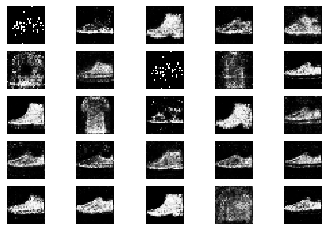

14401 [D loss: 0.332580, acc.: 84.38%] [G loss: 2.400942]
14402 [D loss: 0.258924, acc.: 90.62%] [G loss: 2.026103]
14403 [D loss: 0.245846, acc.: 92.19%] [G loss: 2.040076]
14404 [D loss: 0.304241, acc.: 87.50%] [G loss: 1.875680]
14405 [D loss: 0.245981, acc.: 92.19%] [G loss: 2.245592]
14406 [D loss: 0.379961, acc.: 84.38%] [G loss: 1.994471]
14407 [D loss: 0.262253, acc.: 92.19%] [G loss: 1.940268]
14408 [D loss: 0.334096, acc.: 79.69%] [G loss: 2.098275]
14409 [D loss: 0.255470, acc.: 92.19%] [G loss: 2.151498]
14410 [D loss: 0.376535, acc.: 84.38%] [G loss: 2.527152]
14411 [D loss: 0.283651, acc.: 89.06%] [G loss: 2.184649]
14412 [D loss: 0.381162, acc.: 82.81%] [G loss: 2.239254]
14413 [D loss: 0.301768, acc.: 85.94%] [G loss: 2.333474]
14414 [D loss: 0.271286, acc.: 92.19%] [G loss: 2.347051]
14415 [D loss: 0.433639, acc.: 79.69%] [G loss: 2.106889]
14416 [D loss: 0.455035, acc.: 78.12%] [G loss: 1.755380]
14417 [D loss: 0.419468, acc.: 79.69%] [G loss: 2.174969]
14418 [D loss:

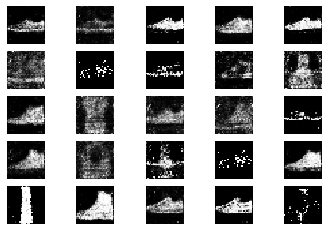

14601 [D loss: 0.370313, acc.: 84.38%] [G loss: 1.885641]
14602 [D loss: 0.430374, acc.: 78.12%] [G loss: 2.096981]
14603 [D loss: 0.279159, acc.: 90.62%] [G loss: 2.296031]
14604 [D loss: 0.373259, acc.: 82.81%] [G loss: 1.985616]
14605 [D loss: 0.371427, acc.: 82.81%] [G loss: 1.668667]
14606 [D loss: 0.327240, acc.: 84.38%] [G loss: 1.936165]
14607 [D loss: 0.344944, acc.: 85.94%] [G loss: 1.827659]
14608 [D loss: 0.305351, acc.: 85.94%] [G loss: 1.856587]
14609 [D loss: 0.385536, acc.: 85.94%] [G loss: 1.893476]
14610 [D loss: 0.323459, acc.: 90.62%] [G loss: 2.013150]
14611 [D loss: 0.318436, acc.: 81.25%] [G loss: 1.700063]
14612 [D loss: 0.371710, acc.: 85.94%] [G loss: 1.993870]
14613 [D loss: 0.395417, acc.: 81.25%] [G loss: 2.241071]
14614 [D loss: 0.373427, acc.: 85.94%] [G loss: 1.960491]
14615 [D loss: 0.238755, acc.: 90.62%] [G loss: 2.459355]
14616 [D loss: 0.284464, acc.: 87.50%] [G loss: 1.984851]
14617 [D loss: 0.304244, acc.: 87.50%] [G loss: 2.932375]
14618 [D loss:

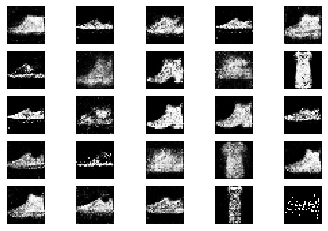

14801 [D loss: 0.335706, acc.: 89.06%] [G loss: 2.020768]
14802 [D loss: 0.340983, acc.: 89.06%] [G loss: 2.155836]
14803 [D loss: 0.396156, acc.: 84.38%] [G loss: 2.105263]
14804 [D loss: 0.501048, acc.: 79.69%] [G loss: 1.777708]
14805 [D loss: 0.309743, acc.: 87.50%] [G loss: 1.934793]
14806 [D loss: 0.308137, acc.: 85.94%] [G loss: 2.015368]
14807 [D loss: 0.289149, acc.: 85.94%] [G loss: 2.278812]
14808 [D loss: 0.303038, acc.: 89.06%] [G loss: 2.347072]
14809 [D loss: 0.389804, acc.: 82.81%] [G loss: 1.924645]
14810 [D loss: 0.324484, acc.: 87.50%] [G loss: 2.626442]
14811 [D loss: 0.369354, acc.: 85.94%] [G loss: 1.920152]
14812 [D loss: 0.292663, acc.: 89.06%] [G loss: 2.125490]
14813 [D loss: 0.306190, acc.: 85.94%] [G loss: 2.564930]
14814 [D loss: 0.358408, acc.: 87.50%] [G loss: 2.359768]
14815 [D loss: 0.288716, acc.: 89.06%] [G loss: 1.950301]
14816 [D loss: 0.179502, acc.: 96.88%] [G loss: 3.225989]
14817 [D loss: 0.266381, acc.: 85.94%] [G loss: 2.476119]
14818 [D loss:

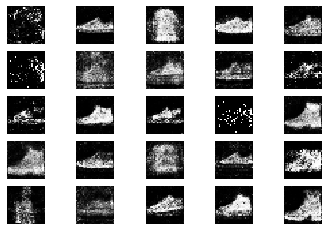

15001 [D loss: 0.267426, acc.: 90.62%] [G loss: 2.387034]
15002 [D loss: 0.304814, acc.: 85.94%] [G loss: 2.493508]
15003 [D loss: 0.414218, acc.: 78.12%] [G loss: 2.203351]
15004 [D loss: 0.258591, acc.: 89.06%] [G loss: 2.117280]
15005 [D loss: 0.274986, acc.: 89.06%] [G loss: 2.526323]
15006 [D loss: 0.303416, acc.: 89.06%] [G loss: 2.156840]
15007 [D loss: 0.244910, acc.: 87.50%] [G loss: 2.430507]
15008 [D loss: 0.270840, acc.: 90.62%] [G loss: 2.220483]
15009 [D loss: 0.230596, acc.: 90.62%] [G loss: 2.498369]
15010 [D loss: 0.501635, acc.: 79.69%] [G loss: 1.839228]
15011 [D loss: 0.362030, acc.: 85.94%] [G loss: 2.474676]
15012 [D loss: 0.401203, acc.: 82.81%] [G loss: 2.186283]
15013 [D loss: 0.523011, acc.: 78.12%] [G loss: 2.392883]
15014 [D loss: 0.244706, acc.: 90.62%] [G loss: 2.592749]
15015 [D loss: 0.405584, acc.: 82.81%] [G loss: 2.033279]
15016 [D loss: 0.201763, acc.: 92.19%] [G loss: 2.664836]
15017 [D loss: 0.476405, acc.: 79.69%] [G loss: 1.986192]
15018 [D loss:

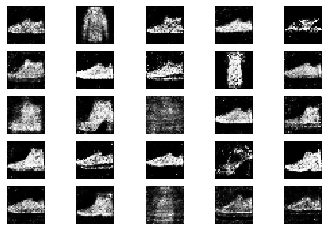

15201 [D loss: 0.299476, acc.: 84.38%] [G loss: 2.352595]
15202 [D loss: 0.347569, acc.: 84.38%] [G loss: 1.930619]
15203 [D loss: 0.248303, acc.: 93.75%] [G loss: 1.926995]
15204 [D loss: 0.262099, acc.: 90.62%] [G loss: 2.142466]
15205 [D loss: 0.205016, acc.: 95.31%] [G loss: 2.416487]
15206 [D loss: 0.500114, acc.: 75.00%] [G loss: 1.980201]
15207 [D loss: 0.401823, acc.: 81.25%] [G loss: 2.160377]
15208 [D loss: 0.308525, acc.: 87.50%] [G loss: 1.953388]
15209 [D loss: 0.414015, acc.: 82.81%] [G loss: 1.970685]
15210 [D loss: 0.287250, acc.: 90.62%] [G loss: 2.033892]
15211 [D loss: 0.283674, acc.: 85.94%] [G loss: 1.917864]
15212 [D loss: 0.186003, acc.: 93.75%] [G loss: 2.279097]
15213 [D loss: 0.369464, acc.: 82.81%] [G loss: 2.243695]
15214 [D loss: 0.351739, acc.: 81.25%] [G loss: 2.200489]
15215 [D loss: 0.195881, acc.: 92.19%] [G loss: 2.419721]
15216 [D loss: 0.284562, acc.: 87.50%] [G loss: 2.263452]
15217 [D loss: 0.399916, acc.: 79.69%] [G loss: 2.520962]
15218 [D loss:

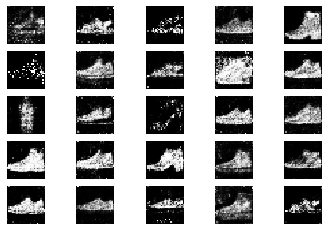

15401 [D loss: 0.276824, acc.: 90.62%] [G loss: 1.839731]
15402 [D loss: 0.299179, acc.: 89.06%] [G loss: 2.264519]
15403 [D loss: 0.267940, acc.: 90.62%] [G loss: 2.418994]
15404 [D loss: 0.413991, acc.: 81.25%] [G loss: 2.310280]
15405 [D loss: 0.282657, acc.: 89.06%] [G loss: 2.469912]
15406 [D loss: 0.287222, acc.: 89.06%] [G loss: 2.252529]
15407 [D loss: 0.242494, acc.: 92.19%] [G loss: 2.196842]
15408 [D loss: 0.258217, acc.: 92.19%] [G loss: 2.940040]
15409 [D loss: 0.263436, acc.: 90.62%] [G loss: 2.969438]
15410 [D loss: 0.351211, acc.: 85.94%] [G loss: 2.254947]
15411 [D loss: 0.423201, acc.: 82.81%] [G loss: 2.059362]
15412 [D loss: 0.241017, acc.: 92.19%] [G loss: 2.197471]
15413 [D loss: 0.300446, acc.: 87.50%] [G loss: 2.272287]
15414 [D loss: 0.369468, acc.: 81.25%] [G loss: 2.059288]
15415 [D loss: 0.315243, acc.: 87.50%] [G loss: 2.388112]
15416 [D loss: 0.474427, acc.: 75.00%] [G loss: 1.907902]
15417 [D loss: 0.349250, acc.: 85.94%] [G loss: 1.886570]
15418 [D loss:

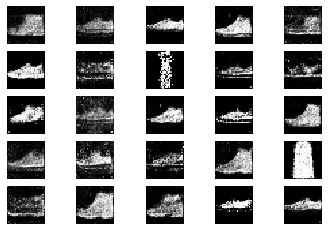

15601 [D loss: 0.295853, acc.: 85.94%] [G loss: 2.048865]
15602 [D loss: 0.455606, acc.: 81.25%] [G loss: 1.784053]
15603 [D loss: 0.410508, acc.: 81.25%] [G loss: 1.996228]
15604 [D loss: 0.354898, acc.: 87.50%] [G loss: 2.259887]
15605 [D loss: 0.312218, acc.: 87.50%] [G loss: 2.308156]
15606 [D loss: 0.376505, acc.: 87.50%] [G loss: 2.011893]
15607 [D loss: 0.356060, acc.: 84.38%] [G loss: 1.778931]
15608 [D loss: 0.218566, acc.: 89.06%] [G loss: 2.203728]
15609 [D loss: 0.421108, acc.: 85.94%] [G loss: 1.946044]
15610 [D loss: 0.331007, acc.: 87.50%] [G loss: 2.049631]
15611 [D loss: 0.278234, acc.: 92.19%] [G loss: 1.880440]
15612 [D loss: 0.221957, acc.: 93.75%] [G loss: 2.087325]
15613 [D loss: 0.376247, acc.: 82.81%] [G loss: 1.993629]
15614 [D loss: 0.206486, acc.: 90.62%] [G loss: 1.889808]
15615 [D loss: 0.475662, acc.: 81.25%] [G loss: 1.694613]
15616 [D loss: 0.325639, acc.: 84.38%] [G loss: 1.945167]
15617 [D loss: 0.449098, acc.: 81.25%] [G loss: 1.883439]
15618 [D loss:

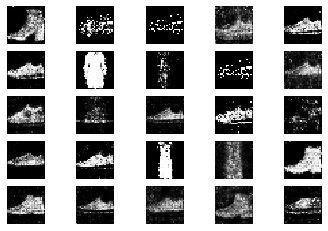

15801 [D loss: 0.332212, acc.: 84.38%] [G loss: 1.770039]
15802 [D loss: 0.306952, acc.: 82.81%] [G loss: 1.967240]
15803 [D loss: 0.348866, acc.: 85.94%] [G loss: 2.241606]
15804 [D loss: 0.343191, acc.: 87.50%] [G loss: 2.318374]
15805 [D loss: 0.279833, acc.: 90.62%] [G loss: 1.968437]
15806 [D loss: 0.491459, acc.: 79.69%] [G loss: 1.934077]
15807 [D loss: 0.219614, acc.: 95.31%] [G loss: 2.004894]
15808 [D loss: 0.277835, acc.: 89.06%] [G loss: 2.160056]
15809 [D loss: 0.280287, acc.: 89.06%] [G loss: 2.038097]
15810 [D loss: 0.402574, acc.: 81.25%] [G loss: 2.172017]
15811 [D loss: 0.310878, acc.: 84.38%] [G loss: 2.378249]
15812 [D loss: 0.277471, acc.: 89.06%] [G loss: 2.243329]
15813 [D loss: 0.318187, acc.: 84.38%] [G loss: 2.030342]
15814 [D loss: 0.472758, acc.: 82.81%] [G loss: 2.448099]
15815 [D loss: 0.360297, acc.: 81.25%] [G loss: 2.036394]
15816 [D loss: 0.362650, acc.: 84.38%] [G loss: 2.199905]
15817 [D loss: 0.258368, acc.: 89.06%] [G loss: 2.343315]
15818 [D loss:

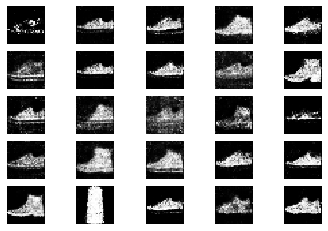

16001 [D loss: 0.181961, acc.: 93.75%] [G loss: 2.424294]
16002 [D loss: 0.486819, acc.: 78.12%] [G loss: 2.077209]
16003 [D loss: 0.359551, acc.: 82.81%] [G loss: 2.123322]
16004 [D loss: 0.274611, acc.: 87.50%] [G loss: 1.909599]
16005 [D loss: 0.283517, acc.: 90.62%] [G loss: 1.630451]
16006 [D loss: 0.370836, acc.: 84.38%] [G loss: 1.727551]
16007 [D loss: 0.443609, acc.: 79.69%] [G loss: 1.826621]
16008 [D loss: 0.316201, acc.: 87.50%] [G loss: 1.786937]
16009 [D loss: 0.308683, acc.: 90.62%] [G loss: 2.099050]
16010 [D loss: 0.312005, acc.: 89.06%] [G loss: 2.258447]
16011 [D loss: 0.469952, acc.: 79.69%] [G loss: 2.118731]
16012 [D loss: 0.361936, acc.: 82.81%] [G loss: 2.356875]
16013 [D loss: 0.424133, acc.: 84.38%] [G loss: 2.030619]
16014 [D loss: 0.473422, acc.: 79.69%] [G loss: 2.089281]
16015 [D loss: 0.291422, acc.: 87.50%] [G loss: 2.235623]
16016 [D loss: 0.225906, acc.: 90.62%] [G loss: 2.091932]
16017 [D loss: 0.239782, acc.: 90.62%] [G loss: 2.197463]
16018 [D loss:

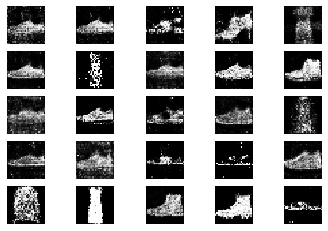

16201 [D loss: 0.408650, acc.: 84.38%] [G loss: 1.946863]
16202 [D loss: 0.218266, acc.: 93.75%] [G loss: 1.863823]
16203 [D loss: 0.366728, acc.: 85.94%] [G loss: 1.538461]
16204 [D loss: 0.331300, acc.: 90.62%] [G loss: 2.109200]
16205 [D loss: 0.329630, acc.: 85.94%] [G loss: 1.612502]
16206 [D loss: 0.343776, acc.: 84.38%] [G loss: 2.487152]
16207 [D loss: 0.168897, acc.: 96.88%] [G loss: 2.290960]
16208 [D loss: 0.335703, acc.: 87.50%] [G loss: 2.142238]
16209 [D loss: 0.385077, acc.: 82.81%] [G loss: 2.374730]
16210 [D loss: 0.385088, acc.: 81.25%] [G loss: 1.947878]
16211 [D loss: 0.308757, acc.: 89.06%] [G loss: 1.996639]
16212 [D loss: 0.328828, acc.: 87.50%] [G loss: 2.012276]
16213 [D loss: 0.359752, acc.: 90.62%] [G loss: 2.318347]
16214 [D loss: 0.393548, acc.: 84.38%] [G loss: 1.847228]
16215 [D loss: 0.307729, acc.: 84.38%] [G loss: 2.278372]
16216 [D loss: 0.349517, acc.: 84.38%] [G loss: 1.898578]
16217 [D loss: 0.310214, acc.: 87.50%] [G loss: 1.881695]
16218 [D loss:

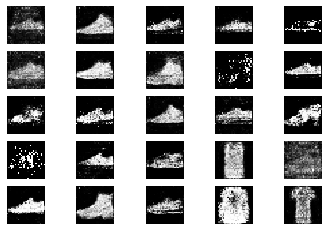

16401 [D loss: 0.166992, acc.: 95.31%] [G loss: 2.517138]
16402 [D loss: 0.494320, acc.: 81.25%] [G loss: 2.457409]
16403 [D loss: 0.259215, acc.: 89.06%] [G loss: 1.988473]
16404 [D loss: 0.390682, acc.: 82.81%] [G loss: 2.092188]
16405 [D loss: 0.495771, acc.: 73.44%] [G loss: 1.921872]
16406 [D loss: 0.228427, acc.: 92.19%] [G loss: 2.338261]
16407 [D loss: 0.199140, acc.: 92.19%] [G loss: 2.219954]
16408 [D loss: 0.439310, acc.: 78.12%] [G loss: 1.870200]
16409 [D loss: 0.320316, acc.: 85.94%] [G loss: 2.038276]
16410 [D loss: 0.264870, acc.: 87.50%] [G loss: 2.362587]
16411 [D loss: 0.409828, acc.: 79.69%] [G loss: 1.984290]
16412 [D loss: 0.285175, acc.: 85.94%] [G loss: 1.942917]
16413 [D loss: 0.224945, acc.: 90.62%] [G loss: 1.932691]
16414 [D loss: 0.333551, acc.: 89.06%] [G loss: 2.176431]
16415 [D loss: 0.330792, acc.: 82.81%] [G loss: 2.320251]
16416 [D loss: 0.136345, acc.: 98.44%] [G loss: 2.147960]
16417 [D loss: 0.300395, acc.: 85.94%] [G loss: 2.298759]
16418 [D loss:

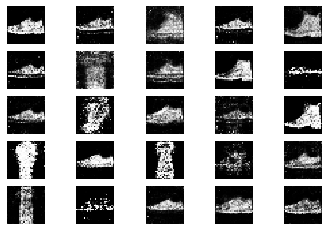

16601 [D loss: 0.314265, acc.: 87.50%] [G loss: 1.818957]
16602 [D loss: 0.318366, acc.: 89.06%] [G loss: 1.943641]
16603 [D loss: 0.335881, acc.: 87.50%] [G loss: 1.954885]
16604 [D loss: 0.323065, acc.: 85.94%] [G loss: 2.242819]
16605 [D loss: 0.293294, acc.: 89.06%] [G loss: 2.204329]
16606 [D loss: 0.575001, acc.: 73.44%] [G loss: 2.057956]
16607 [D loss: 0.266617, acc.: 89.06%] [G loss: 2.644911]
16608 [D loss: 0.260611, acc.: 90.62%] [G loss: 2.289915]
16609 [D loss: 0.201814, acc.: 93.75%] [G loss: 2.308759]
16610 [D loss: 0.237808, acc.: 87.50%] [G loss: 2.464186]
16611 [D loss: 0.318825, acc.: 87.50%] [G loss: 2.340600]
16612 [D loss: 0.367874, acc.: 82.81%] [G loss: 2.135746]
16613 [D loss: 0.503250, acc.: 79.69%] [G loss: 2.142828]
16614 [D loss: 0.377678, acc.: 82.81%] [G loss: 1.929263]
16615 [D loss: 0.272107, acc.: 87.50%] [G loss: 2.106003]
16616 [D loss: 0.272793, acc.: 87.50%] [G loss: 2.144956]
16617 [D loss: 0.371531, acc.: 85.94%] [G loss: 2.368894]
16618 [D loss:

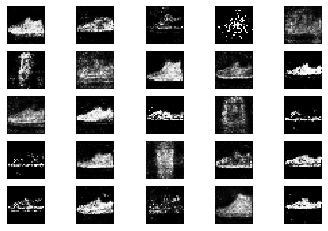

16801 [D loss: 0.392352, acc.: 82.81%] [G loss: 2.375663]
16802 [D loss: 0.389232, acc.: 84.38%] [G loss: 2.606516]
16803 [D loss: 0.272066, acc.: 87.50%] [G loss: 2.042882]
16804 [D loss: 0.359005, acc.: 82.81%] [G loss: 2.932001]
16805 [D loss: 0.370578, acc.: 82.81%] [G loss: 2.853274]
16806 [D loss: 0.252051, acc.: 89.06%] [G loss: 2.168235]
16807 [D loss: 0.322211, acc.: 84.38%] [G loss: 2.500432]
16808 [D loss: 0.463583, acc.: 78.12%] [G loss: 2.862127]
16809 [D loss: 0.333961, acc.: 85.94%] [G loss: 2.450742]
16810 [D loss: 0.221607, acc.: 90.62%] [G loss: 2.842745]
16811 [D loss: 0.310121, acc.: 87.50%] [G loss: 2.450390]
16812 [D loss: 0.354419, acc.: 85.94%] [G loss: 1.673873]
16813 [D loss: 0.238803, acc.: 90.62%] [G loss: 2.124384]
16814 [D loss: 0.468348, acc.: 71.88%] [G loss: 2.242384]
16815 [D loss: 0.309384, acc.: 85.94%] [G loss: 2.266950]
16816 [D loss: 0.237201, acc.: 89.06%] [G loss: 2.432151]
16817 [D loss: 0.372311, acc.: 85.94%] [G loss: 2.383462]
16818 [D loss:

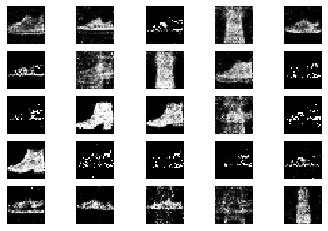

17001 [D loss: 0.361707, acc.: 82.81%] [G loss: 2.439775]
17002 [D loss: 0.343942, acc.: 90.62%] [G loss: 2.055342]
17003 [D loss: 0.335805, acc.: 87.50%] [G loss: 2.004050]
17004 [D loss: 0.391287, acc.: 82.81%] [G loss: 1.908397]
17005 [D loss: 0.351161, acc.: 85.94%] [G loss: 2.296632]
17006 [D loss: 0.234798, acc.: 89.06%] [G loss: 2.044047]
17007 [D loss: 0.228068, acc.: 90.62%] [G loss: 2.592948]
17008 [D loss: 0.351751, acc.: 84.38%] [G loss: 2.194840]
17009 [D loss: 0.255600, acc.: 90.62%] [G loss: 2.080512]
17010 [D loss: 0.402977, acc.: 84.38%] [G loss: 1.927970]
17011 [D loss: 0.304723, acc.: 87.50%] [G loss: 1.844228]
17012 [D loss: 0.237575, acc.: 90.62%] [G loss: 2.010361]
17013 [D loss: 0.231361, acc.: 93.75%] [G loss: 2.323839]
17014 [D loss: 0.474550, acc.: 81.25%] [G loss: 2.185989]
17015 [D loss: 0.316361, acc.: 87.50%] [G loss: 2.424993]
17016 [D loss: 0.266876, acc.: 90.62%] [G loss: 2.571904]
17017 [D loss: 0.580221, acc.: 73.44%] [G loss: 1.726226]
17018 [D loss:

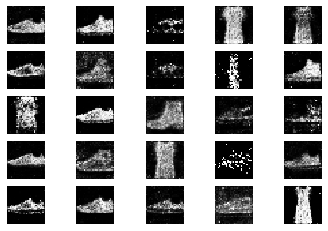

17201 [D loss: 0.339651, acc.: 85.94%] [G loss: 2.061722]
17202 [D loss: 0.286475, acc.: 85.94%] [G loss: 2.001973]
17203 [D loss: 0.491761, acc.: 78.12%] [G loss: 1.603082]
17204 [D loss: 0.384311, acc.: 79.69%] [G loss: 1.950712]
17205 [D loss: 0.480574, acc.: 75.00%] [G loss: 1.995945]
17206 [D loss: 0.432275, acc.: 75.00%] [G loss: 1.988926]
17207 [D loss: 0.362145, acc.: 84.38%] [G loss: 1.806888]
17208 [D loss: 0.365457, acc.: 81.25%] [G loss: 1.791766]
17209 [D loss: 0.233114, acc.: 92.19%] [G loss: 1.979566]
17210 [D loss: 0.322567, acc.: 87.50%] [G loss: 1.906631]
17211 [D loss: 0.424537, acc.: 89.06%] [G loss: 2.335458]
17212 [D loss: 0.309190, acc.: 90.62%] [G loss: 2.288783]
17213 [D loss: 0.418072, acc.: 82.81%] [G loss: 2.112550]
17214 [D loss: 0.348300, acc.: 85.94%] [G loss: 2.025083]
17215 [D loss: 0.348134, acc.: 84.38%] [G loss: 2.083153]
17216 [D loss: 0.302272, acc.: 85.94%] [G loss: 2.350404]
17217 [D loss: 0.208270, acc.: 92.19%] [G loss: 2.237536]
17218 [D loss:

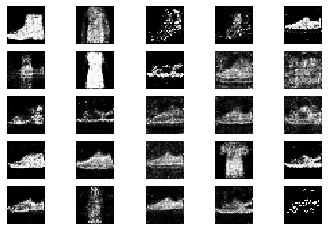

17401 [D loss: 0.403111, acc.: 82.81%] [G loss: 1.973570]
17402 [D loss: 0.210615, acc.: 92.19%] [G loss: 2.416290]
17403 [D loss: 0.287143, acc.: 87.50%] [G loss: 1.950548]
17404 [D loss: 0.191725, acc.: 95.31%] [G loss: 2.130976]
17405 [D loss: 0.213627, acc.: 92.19%] [G loss: 2.579992]
17406 [D loss: 0.286745, acc.: 87.50%] [G loss: 2.645924]
17407 [D loss: 0.478932, acc.: 76.56%] [G loss: 2.186894]
17408 [D loss: 0.236921, acc.: 92.19%] [G loss: 1.982119]
17409 [D loss: 0.282527, acc.: 85.94%] [G loss: 2.121284]
17410 [D loss: 0.200725, acc.: 95.31%] [G loss: 2.310289]
17411 [D loss: 0.538234, acc.: 76.56%] [G loss: 2.005526]
17412 [D loss: 0.312668, acc.: 87.50%] [G loss: 1.995113]
17413 [D loss: 0.256968, acc.: 90.62%] [G loss: 2.188797]
17414 [D loss: 0.309534, acc.: 85.94%] [G loss: 2.163905]
17415 [D loss: 0.336859, acc.: 85.94%] [G loss: 2.073869]
17416 [D loss: 0.379481, acc.: 84.38%] [G loss: 2.157888]
17417 [D loss: 0.399974, acc.: 81.25%] [G loss: 2.255033]
17418 [D loss:

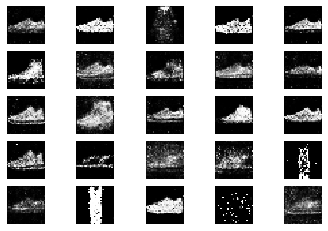

17601 [D loss: 0.330878, acc.: 85.94%] [G loss: 2.037142]
17602 [D loss: 0.305774, acc.: 89.06%] [G loss: 2.015402]
17603 [D loss: 0.381727, acc.: 85.94%] [G loss: 1.931302]
17604 [D loss: 0.231223, acc.: 89.06%] [G loss: 1.836556]
17605 [D loss: 0.389174, acc.: 79.69%] [G loss: 2.277872]
17606 [D loss: 0.347860, acc.: 84.38%] [G loss: 2.192059]
17607 [D loss: 0.322196, acc.: 84.38%] [G loss: 2.181387]
17608 [D loss: 0.325287, acc.: 85.94%] [G loss: 2.256909]
17609 [D loss: 0.215415, acc.: 89.06%] [G loss: 2.349540]
17610 [D loss: 0.319523, acc.: 89.06%] [G loss: 2.086405]
17611 [D loss: 0.359702, acc.: 87.50%] [G loss: 1.823667]
17612 [D loss: 0.245113, acc.: 92.19%] [G loss: 1.961371]
17613 [D loss: 0.402568, acc.: 82.81%] [G loss: 2.262861]
17614 [D loss: 0.288362, acc.: 89.06%] [G loss: 1.878631]
17615 [D loss: 0.304709, acc.: 87.50%] [G loss: 2.408111]
17616 [D loss: 0.277911, acc.: 89.06%] [G loss: 2.087194]
17617 [D loss: 0.290317, acc.: 85.94%] [G loss: 2.290921]
17618 [D loss:

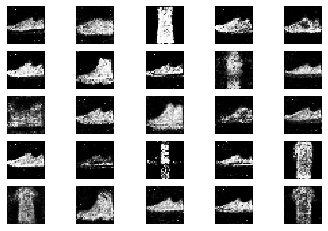

17801 [D loss: 0.380361, acc.: 84.38%] [G loss: 2.165674]
17802 [D loss: 0.385938, acc.: 81.25%] [G loss: 1.955640]
17803 [D loss: 0.268109, acc.: 90.62%] [G loss: 2.156690]
17804 [D loss: 0.237018, acc.: 90.62%] [G loss: 2.212870]
17805 [D loss: 0.334726, acc.: 82.81%] [G loss: 2.045018]
17806 [D loss: 0.411038, acc.: 82.81%] [G loss: 2.210585]
17807 [D loss: 0.278179, acc.: 87.50%] [G loss: 1.912379]
17808 [D loss: 0.321804, acc.: 89.06%] [G loss: 1.913943]
17809 [D loss: 0.306618, acc.: 84.38%] [G loss: 2.176364]
17810 [D loss: 0.297435, acc.: 87.50%] [G loss: 2.226203]
17811 [D loss: 0.337443, acc.: 84.38%] [G loss: 2.310579]
17812 [D loss: 0.375654, acc.: 87.50%] [G loss: 2.086581]
17813 [D loss: 0.332244, acc.: 87.50%] [G loss: 1.895321]
17814 [D loss: 0.227427, acc.: 92.19%] [G loss: 2.113201]
17815 [D loss: 0.376071, acc.: 84.38%] [G loss: 2.127853]
17816 [D loss: 0.297283, acc.: 85.94%] [G loss: 2.246202]
17817 [D loss: 0.308052, acc.: 85.94%] [G loss: 2.203467]
17818 [D loss:

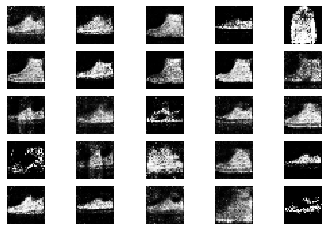

18001 [D loss: 0.218857, acc.: 93.75%] [G loss: 2.448054]
18002 [D loss: 0.211288, acc.: 90.62%] [G loss: 2.482984]
18003 [D loss: 0.253827, acc.: 90.62%] [G loss: 2.454582]
18004 [D loss: 0.430998, acc.: 79.69%] [G loss: 2.204399]
18005 [D loss: 0.420680, acc.: 82.81%] [G loss: 2.106692]
18006 [D loss: 0.434327, acc.: 79.69%] [G loss: 1.990060]
18007 [D loss: 0.159983, acc.: 96.88%] [G loss: 2.729705]
18008 [D loss: 0.341315, acc.: 84.38%] [G loss: 2.093751]
18009 [D loss: 0.361296, acc.: 87.50%] [G loss: 2.892591]
18010 [D loss: 0.283723, acc.: 89.06%] [G loss: 3.693155]
18011 [D loss: 0.254498, acc.: 89.06%] [G loss: 2.771897]
18012 [D loss: 0.325008, acc.: 81.25%] [G loss: 3.209440]
18013 [D loss: 0.406815, acc.: 79.69%] [G loss: 2.217037]
18014 [D loss: 0.352480, acc.: 84.38%] [G loss: 2.196367]
18015 [D loss: 0.372817, acc.: 82.81%] [G loss: 2.124084]
18016 [D loss: 0.219854, acc.: 92.19%] [G loss: 2.015084]
18017 [D loss: 0.416259, acc.: 84.38%] [G loss: 2.011763]
18018 [D loss:

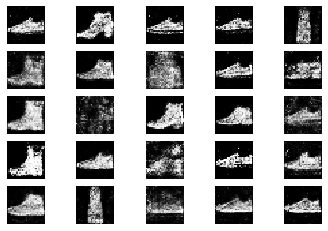

18201 [D loss: 0.252912, acc.: 92.19%] [G loss: 2.255417]
18202 [D loss: 0.429765, acc.: 81.25%] [G loss: 2.289011]
18203 [D loss: 0.346622, acc.: 79.69%] [G loss: 2.132679]
18204 [D loss: 0.280985, acc.: 87.50%] [G loss: 1.803659]
18205 [D loss: 0.366623, acc.: 84.38%] [G loss: 1.918442]
18206 [D loss: 0.197768, acc.: 95.31%] [G loss: 2.016985]
18207 [D loss: 0.302812, acc.: 87.50%] [G loss: 2.100034]
18208 [D loss: 0.364395, acc.: 85.94%] [G loss: 1.928093]
18209 [D loss: 0.362696, acc.: 84.38%] [G loss: 2.126550]
18210 [D loss: 0.338128, acc.: 87.50%] [G loss: 2.125075]
18211 [D loss: 0.337908, acc.: 89.06%] [G loss: 1.900195]
18212 [D loss: 0.294458, acc.: 85.94%] [G loss: 2.137231]
18213 [D loss: 0.317498, acc.: 87.50%] [G loss: 2.277448]
18214 [D loss: 0.305292, acc.: 84.38%] [G loss: 2.510012]
18215 [D loss: 0.236768, acc.: 92.19%] [G loss: 2.380222]
18216 [D loss: 0.310830, acc.: 90.62%] [G loss: 2.620688]
18217 [D loss: 0.365322, acc.: 81.25%] [G loss: 1.861157]
18218 [D loss:

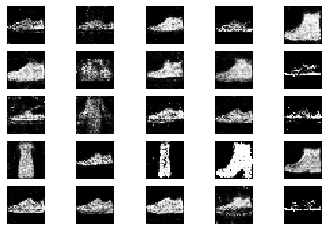

18401 [D loss: 0.438478, acc.: 79.69%] [G loss: 1.930267]
18402 [D loss: 0.357556, acc.: 81.25%] [G loss: 2.570698]
18403 [D loss: 0.243727, acc.: 90.62%] [G loss: 2.222406]
18404 [D loss: 0.301160, acc.: 85.94%] [G loss: 1.743445]
18405 [D loss: 0.326458, acc.: 81.25%] [G loss: 2.855326]
18406 [D loss: 0.306491, acc.: 87.50%] [G loss: 2.109655]
18407 [D loss: 0.352120, acc.: 82.81%] [G loss: 1.951873]
18408 [D loss: 0.354622, acc.: 84.38%] [G loss: 2.381771]
18409 [D loss: 0.370165, acc.: 76.56%] [G loss: 2.365770]
18410 [D loss: 0.325093, acc.: 87.50%] [G loss: 2.332751]
18411 [D loss: 0.367244, acc.: 85.94%] [G loss: 2.412007]
18412 [D loss: 0.493496, acc.: 81.25%] [G loss: 2.560439]
18413 [D loss: 0.284957, acc.: 92.19%] [G loss: 2.169985]
18414 [D loss: 0.535946, acc.: 82.81%] [G loss: 1.834239]
18415 [D loss: 0.368849, acc.: 79.69%] [G loss: 1.891790]
18416 [D loss: 0.191470, acc.: 96.88%] [G loss: 2.094979]
18417 [D loss: 0.367723, acc.: 82.81%] [G loss: 2.003377]
18418 [D loss:

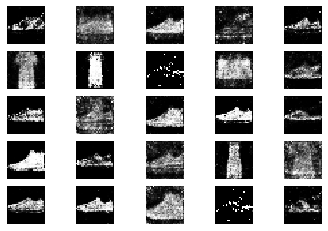

18601 [D loss: 0.252803, acc.: 90.62%] [G loss: 1.872292]
18602 [D loss: 0.307411, acc.: 85.94%] [G loss: 2.130814]
18603 [D loss: 0.411029, acc.: 79.69%] [G loss: 2.215559]
18604 [D loss: 0.461298, acc.: 73.44%] [G loss: 1.847849]
18605 [D loss: 0.280376, acc.: 84.38%] [G loss: 2.088680]
18606 [D loss: 0.254279, acc.: 90.62%] [G loss: 1.934282]
18607 [D loss: 0.239717, acc.: 89.06%] [G loss: 2.101628]
18608 [D loss: 0.331732, acc.: 82.81%] [G loss: 1.815112]
18609 [D loss: 0.242845, acc.: 85.94%] [G loss: 1.958849]
18610 [D loss: 0.306644, acc.: 85.94%] [G loss: 2.174818]
18611 [D loss: 0.291549, acc.: 87.50%] [G loss: 2.230786]
18612 [D loss: 0.478195, acc.: 78.12%] [G loss: 2.162264]
18613 [D loss: 0.361378, acc.: 85.94%] [G loss: 2.229482]
18614 [D loss: 0.375418, acc.: 78.12%] [G loss: 2.599838]
18615 [D loss: 0.498151, acc.: 73.44%] [G loss: 2.017852]
18616 [D loss: 0.376923, acc.: 81.25%] [G loss: 2.090870]
18617 [D loss: 0.335852, acc.: 85.94%] [G loss: 1.882073]
18618 [D loss:

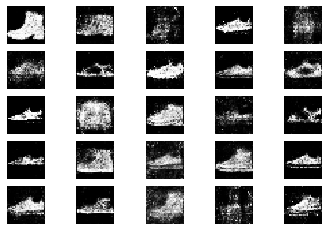

18801 [D loss: 0.221921, acc.: 89.06%] [G loss: 2.519348]
18802 [D loss: 0.246949, acc.: 90.62%] [G loss: 2.164407]
18803 [D loss: 0.258962, acc.: 90.62%] [G loss: 2.357772]
18804 [D loss: 0.320120, acc.: 82.81%] [G loss: 2.213295]
18805 [D loss: 0.383300, acc.: 87.50%] [G loss: 1.911695]
18806 [D loss: 0.400277, acc.: 85.94%] [G loss: 2.172743]
18807 [D loss: 0.397062, acc.: 84.38%] [G loss: 2.392304]
18808 [D loss: 0.376929, acc.: 84.38%] [G loss: 2.186739]
18809 [D loss: 0.203858, acc.: 92.19%] [G loss: 2.339278]
18810 [D loss: 0.318286, acc.: 82.81%] [G loss: 2.071450]
18811 [D loss: 0.336034, acc.: 89.06%] [G loss: 1.932208]
18812 [D loss: 0.262740, acc.: 90.62%] [G loss: 2.192144]
18813 [D loss: 0.291943, acc.: 87.50%] [G loss: 1.953787]
18814 [D loss: 0.296522, acc.: 90.62%] [G loss: 1.993689]
18815 [D loss: 0.298507, acc.: 89.06%] [G loss: 2.367932]
18816 [D loss: 0.304999, acc.: 85.94%] [G loss: 2.306129]
18817 [D loss: 0.453571, acc.: 76.56%] [G loss: 1.895178]
18818 [D loss:

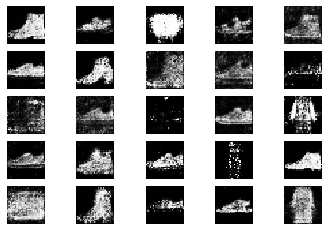

19001 [D loss: 0.292165, acc.: 87.50%] [G loss: 1.828855]
19002 [D loss: 0.438796, acc.: 75.00%] [G loss: 1.904297]
19003 [D loss: 0.256493, acc.: 93.75%] [G loss: 2.643365]
19004 [D loss: 0.402590, acc.: 76.56%] [G loss: 2.474480]
19005 [D loss: 0.445710, acc.: 81.25%] [G loss: 1.729362]
19006 [D loss: 0.312000, acc.: 87.50%] [G loss: 1.796655]
19007 [D loss: 0.243636, acc.: 92.19%] [G loss: 1.979389]
19008 [D loss: 0.287212, acc.: 85.94%] [G loss: 2.183720]
19009 [D loss: 0.270302, acc.: 90.62%] [G loss: 2.132661]
19010 [D loss: 0.412961, acc.: 78.12%] [G loss: 2.095537]
19011 [D loss: 0.342601, acc.: 85.94%] [G loss: 1.861945]
19012 [D loss: 0.267290, acc.: 89.06%] [G loss: 2.327231]
19013 [D loss: 0.242519, acc.: 90.62%] [G loss: 2.128576]
19014 [D loss: 0.282273, acc.: 90.62%] [G loss: 2.543941]
19015 [D loss: 0.356257, acc.: 81.25%] [G loss: 1.862510]
19016 [D loss: 0.224628, acc.: 93.75%] [G loss: 1.894204]
19017 [D loss: 0.277317, acc.: 89.06%] [G loss: 2.759299]
19018 [D loss:

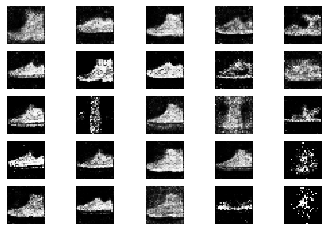

19201 [D loss: 0.295127, acc.: 85.94%] [G loss: 2.318688]
19202 [D loss: 0.366841, acc.: 82.81%] [G loss: 1.697584]
19203 [D loss: 0.299595, acc.: 87.50%] [G loss: 2.136287]
19204 [D loss: 0.221152, acc.: 90.62%] [G loss: 2.293209]
19205 [D loss: 0.221102, acc.: 92.19%] [G loss: 2.257889]
19206 [D loss: 0.288644, acc.: 87.50%] [G loss: 2.324254]
19207 [D loss: 0.317093, acc.: 87.50%] [G loss: 2.308433]
19208 [D loss: 0.312043, acc.: 87.50%] [G loss: 2.600929]
19209 [D loss: 0.479325, acc.: 78.12%] [G loss: 2.279911]
19210 [D loss: 0.498222, acc.: 76.56%] [G loss: 2.368507]
19211 [D loss: 0.380184, acc.: 85.94%] [G loss: 2.054904]
19212 [D loss: 0.379654, acc.: 81.25%] [G loss: 2.118218]
19213 [D loss: 0.311795, acc.: 85.94%] [G loss: 2.392099]
19214 [D loss: 0.341101, acc.: 89.06%] [G loss: 1.716749]
19215 [D loss: 0.395816, acc.: 89.06%] [G loss: 2.151411]
19216 [D loss: 0.215380, acc.: 93.75%] [G loss: 2.377635]
19217 [D loss: 0.379053, acc.: 82.81%] [G loss: 1.936709]
19218 [D loss:

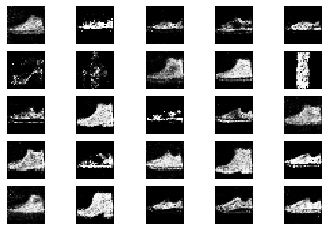

19401 [D loss: 0.268286, acc.: 90.62%] [G loss: 1.850270]
19402 [D loss: 0.337945, acc.: 85.94%] [G loss: 2.007656]
19403 [D loss: 0.310549, acc.: 89.06%] [G loss: 2.056903]
19404 [D loss: 0.267240, acc.: 87.50%] [G loss: 2.131124]
19405 [D loss: 0.256881, acc.: 92.19%] [G loss: 2.159420]
19406 [D loss: 0.313870, acc.: 85.94%] [G loss: 2.304471]
19407 [D loss: 0.328283, acc.: 84.38%] [G loss: 1.961557]
19408 [D loss: 0.436456, acc.: 79.69%] [G loss: 2.037123]
19409 [D loss: 0.325013, acc.: 84.38%] [G loss: 1.725985]
19410 [D loss: 0.273094, acc.: 87.50%] [G loss: 1.817401]
19411 [D loss: 0.404390, acc.: 85.94%] [G loss: 2.031395]
19412 [D loss: 0.198915, acc.: 95.31%] [G loss: 2.267687]
19413 [D loss: 0.512443, acc.: 79.69%] [G loss: 2.212858]
19414 [D loss: 0.353605, acc.: 82.81%] [G loss: 2.433059]
19415 [D loss: 0.252383, acc.: 90.62%] [G loss: 2.293557]
19416 [D loss: 0.434501, acc.: 84.38%] [G loss: 2.583994]
19417 [D loss: 0.230322, acc.: 95.31%] [G loss: 2.597292]
19418 [D loss:

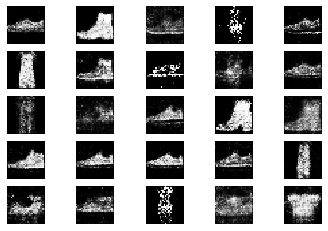

19601 [D loss: 0.304823, acc.: 89.06%] [G loss: 1.912016]
19602 [D loss: 0.359782, acc.: 84.38%] [G loss: 2.055634]
19603 [D loss: 0.195110, acc.: 92.19%] [G loss: 2.051320]
19604 [D loss: 0.400846, acc.: 84.38%] [G loss: 2.631259]
19605 [D loss: 0.380377, acc.: 82.81%] [G loss: 1.884309]
19606 [D loss: 0.279416, acc.: 89.06%] [G loss: 1.779216]
19607 [D loss: 0.272328, acc.: 89.06%] [G loss: 1.921635]
19608 [D loss: 0.357416, acc.: 82.81%] [G loss: 2.004220]
19609 [D loss: 0.304191, acc.: 89.06%] [G loss: 1.996192]
19610 [D loss: 0.294361, acc.: 90.62%] [G loss: 2.083548]
19611 [D loss: 0.269849, acc.: 90.62%] [G loss: 1.758343]
19612 [D loss: 0.239759, acc.: 92.19%] [G loss: 2.249611]
19613 [D loss: 0.378773, acc.: 85.94%] [G loss: 2.115906]
19614 [D loss: 0.344560, acc.: 84.38%] [G loss: 1.865751]
19615 [D loss: 0.299888, acc.: 87.50%] [G loss: 1.894306]
19616 [D loss: 0.302333, acc.: 89.06%] [G loss: 1.891796]
19617 [D loss: 0.242954, acc.: 89.06%] [G loss: 1.996550]
19618 [D loss:

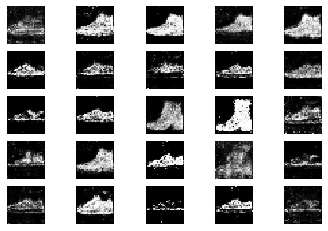

19801 [D loss: 0.356328, acc.: 85.94%] [G loss: 1.900159]
19802 [D loss: 0.367114, acc.: 84.38%] [G loss: 2.186864]
19803 [D loss: 0.467718, acc.: 76.56%] [G loss: 1.727391]
19804 [D loss: 0.341314, acc.: 87.50%] [G loss: 1.737257]
19805 [D loss: 0.300023, acc.: 85.94%] [G loss: 1.927003]
19806 [D loss: 0.312797, acc.: 85.94%] [G loss: 1.813331]
19807 [D loss: 0.234737, acc.: 92.19%] [G loss: 2.069076]
19808 [D loss: 0.361825, acc.: 84.38%] [G loss: 1.874403]
19809 [D loss: 0.474713, acc.: 79.69%] [G loss: 1.903775]
19810 [D loss: 0.317645, acc.: 90.62%] [G loss: 1.820092]
19811 [D loss: 0.291078, acc.: 89.06%] [G loss: 2.105886]
19812 [D loss: 0.318586, acc.: 85.94%] [G loss: 2.044063]
19813 [D loss: 0.283383, acc.: 89.06%] [G loss: 2.130254]
19814 [D loss: 0.261230, acc.: 89.06%] [G loss: 1.856214]
19815 [D loss: 0.244729, acc.: 93.75%] [G loss: 2.226141]
19816 [D loss: 0.203560, acc.: 93.75%] [G loss: 2.151021]
19817 [D loss: 0.407188, acc.: 81.25%] [G loss: 2.018308]
19818 [D loss:

In [8]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=20000, batch_size=32, sample_interval=200)

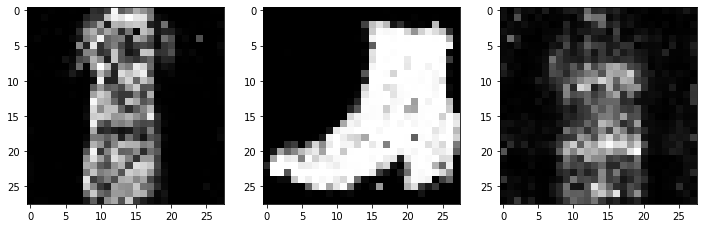

In [20]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r*c, 100))
gen_imgs = gan.generator.predict(noise)

gen_imgs = 0.5*gen_imgs+0.5

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
plt.subplot(132)
plt.imshow(gen_imgs[1, :, :, 0], cmap='gray')
plt.subplot(133)
plt.imshow(gen_imgs[2, :, :, 0], cmap='gray')
plt.show()
plt.close()